In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from modules import network,mlp
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 2000) (8569, 1)


,2,10,13,41,45,62,68,106,133,147,...,19763,19786,19808,19854,19883,20021,20073,20109,20121,20124
0,0.0,1.302199,0.0,0.0,0.0,0.000000,0.36896,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.637877,0.368960
1,0.0,1.351171,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.888292,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.711146,0.00000,0.0,0.0,0.0,...,0.0,0.417500,0.0,0.0,0.93785,0.0,0.0,0.0,0.937850,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.509045,0.00000,0.0,0.0,0.0,...,0.0,0.509045,0.0,0.0,0.00000,0.0,0.0,0.0,0.509045,0.509045


In [4]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

scGenDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

2000
1024
1024
2000
1024
1024


In [5]:
num_elements=len(scDataset)
dim=high_var_gene
print(num_elements,dim)
p=hnswlib.Index(space='cosine',dim=dim)
p.init_index(max_elements=num_elements, ef_construction=100, M=16)
p.set_ef(100)
p.set_num_threads(4)
p.add_items(x_ndarray)

8569 2000


In [6]:
# initialize model
mlp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [7]:
class InstanceLoss(nn.Module):

    def __init__(self,batch_size,temperature,device):
        super(InstanceLoss,self).__init__()
        self.batch_size=batch_size
        self.temperature=temperature
        self.device=device

        self.mask=self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


    def mask_correlated_samples(self,batch_size):
        N=2*batch_size
        mask=torch.ones(N,N)
        mask=mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i,batch_size+1]=0
            mask[batch_size+i,i]=0
        mask=mask.bool()
        return mask

    def forward(self,z_i,z_j):
        N=2*self.batch_size
        z=torch.cat((z_i,z_j),dim=0)

        sim=torch.matmul(z,z.T)/self.temperature
        sim_i_j=torch.diag(sim,self.batch_size)
        sim_j_i=torch.diag(sim,-self.batch_size)

        positive_samples= torch.cat((sim_i_j,sim_j_i),dim=0).reshape(N,1)
        negative_samples=sim[self.mask].reshape(N,-1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [8]:
class ClusterLoss(nn.Module):
    def __init__(self, class_num, temperature, device):
        super(ClusterLoss, self).__init__()
        self.class_num = class_num
        self.temperature = temperature
        self.device = device

        self.mask = self.mask_correlated_clusters(class_num)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_clusters(self, class_num):
        N = 2 * class_num
        mask = torch.ones((N, N))
        mask = mask.fill_diagonal_(0)
        for i in range(class_num):
            mask[i, class_num + i] = 0
            mask[class_num + i, i] = 0
        mask = mask.bool()
        return mask

    def forward(self, c_i, c_j):
        p_i = c_i.sum(0).view(-1)
        p_i /= p_i.sum()
        ne_i = math.log(p_i.size(0)) + (p_i * torch.log(p_i)).sum()
        p_j = c_j.sum(0).view(-1)
        p_j /= p_j.sum()
        ne_j = math.log(p_j.size(0)) + (p_j * torch.log(p_j)).sum()
        ne_loss = ne_i + ne_j

        c_i = c_i.t()
        c_j = c_j.t()
        N = 2 * self.class_num
        c = torch.cat((c_i, c_j), dim=0)

        sim = self.similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, self.class_num)
        sim_j_i = torch.diag(sim, -self.class_num)

        positive_clusters = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_clusters = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_clusters.device).long()
        logits = torch.cat((positive_clusters, negative_clusters), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss + ne_loss


In [9]:
class MemoryBank():

    # 初始化，传入参数
    def __init__(self,batch_size,full_data,topK=10):
        self.topK=topK
        self.batch_size=batch_size
        self.bank=None
        self.full_data=full_data

    # 根据在updateBank中更新的hnsw对象以及输入的数据data（这里可以是embedding）提取TopK个近邻的数据
    # 返回的结果是一个形状为[TopK,batch_size,num_genes]的数组，从第一个维度来看，
    # 每个[batch_size,num_genes]的子数组都是根据输入的数据data寻找的一个近邻，一共TopK个
    def generateContrast(self,data):
        if self.bank is not None:
            contrasts=np.empty((self.topK,args.batch_size,args.num_genes))
            labels,distances=self.bank.knn_query(data,k=self.topK)
            
            # print(labels)

            for step,label in enumerate(labels):
                contrasts[:,step]=self.full_data[label.tolist()]
            return contrasts
        else:
            print('Memory Bank has not been initialized......')
            raise NotImplementedError()

    # 根据输入的embedding更新hnsw对象
    def updateBank(self,embedding):
        num_elements=len(embedding)
        dim=embedding.shape[1]
        self.bank=hnswlib.Index(space='cosine',dim=dim)
        self.bank.init_index(max_elements=num_elements, ef_construction=100, M=16)
        self.bank.set_ef(100)
        self.bank.set_num_threads(4)
        self.bank.add_items(embedding)

In [10]:

# def train(instance_loss,cluster_loss):
#     loss_epoch = 0
#     for step, (data,label) in enumerate(scDataset):
#         optimizer.zero_grad()
        
#         x_i=data.clone().numpy()
        
#         labels, distances = p.knn_query(x_i, k=31)
#         labels=labels.squeeze()
#         contrastive=x_ndarray[labels.tolist()]
#         input=np.row_stack((contrastive,x_i))
#         input_1=input.copy()
#         np.random.shuffle(input_1)
#         x_a=torch.from_numpy(input).to('cuda')
#         x_b=torch.from_numpy(input_1).to('cuda')
        
#         z_i,z_j,c_i,c_j=model(x_a,x_b)
#         loss_instance=instance_loss(z_i,z_j)
#         loss_cluster=cluster_loss(c_i,c_j)
#         loss = loss_instance + loss_cluster
#         loss.backward()
#         optimizer.step()
#         if step % 1000 == 0:
#             print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
#         loss_epoch += loss.item()
#     return loss_epoch


In [11]:
def train(instance_loss,cluster_loss,memory_bank,model,epoch):
    loss_epoch=0
    for step,(data,label) in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        # if epoch<20:
        embedding_data=data.numpy().copy()
        data=data.to('cuda')
        # else:
        #     data=data.to('cuda')
        #     embedding_data=model.forward_embedding(data).cpu().detach().numpy()    
        contrast_samples=memory_bank.generateContrast(embedding_data)
        iter_times=contrast_samples.shape[0]
        for sample in contrast_samples:
            # print(f'sample shape:\n{sample.shape}')
            # print(f'data shape:\n{data.shape}')
            x_i=data.clone()
            x_j=torch.tensor(sample,dtype=torch.float32).to('cuda')

            z_i,z_j,c_i,c_j=model(x_i,x_j)
            loss_instance=instance_loss(z_i,z_j)
            loss_cluster=cluster_loss(c_i,c_j)
            loss = loss_instance + loss_cluster
            # print(f'------ loss:\n{loss}')
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()
        if step % 2 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
            
    return loss_epoch/iter_times

In [12]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 1000 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [13]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scDataLoader, model, device)
    # print(X.shape,Y.shape)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    # print('NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    return nmi, ari, f, acc

In [14]:
loss_device=torch.device('cuda')
instance_loss=InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
aris=[]
nmis=[]
fs=[]

memory_bank=MemoryBank(batch_size=args.batch_size,full_data=x_ndarray,topK=10)
memory_bank.updateBank(x_ndarray)

for epoch in range(args.start_epoch, args.epochs):
    lr = optimizer.param_groups[0]["lr"]
    # if epoch %20 ==0:
    #     embeddings=np.empty((0,mlp.rep_dim))
    #     model.eval()
    #     with torch.no_grad():
    #         for step, (x, y) in enumerate(scGenDataLoader):
    #             x=x.to('cuda')
    #             embedding=model.forward_embedding(x).cpu().detach().numpy()                 
    #             embeddings=np.row_stack((embeddings,embedding))
    #             memory_bank.updateBank(embeddings)
    loss_epoch = train(instance_loss,cluster_loss,memory_bank,epoch=epoch,model=model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 10 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    aris.append(ari)
    nmis.append(nmi)
    fs.append(f)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 7.61228609085083	 loss_cluster: 3.297912836074829
Step [2/8]	 loss_instance: 7.445685863494873	 loss_cluster: 3.2972912788391113
Step [4/8]	 loss_instance: 7.142418384552002	 loss_cluster: 3.294926404953003
Step [6/8]	 loss_instance: 7.0496087074279785	 loss_cluster: 3.2867186069488525

Epoch [1/500]	 Loss: 10.603483784198762 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4518 ARI = 0.2688 F = 0.4857 ACC = 0.4720



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 7.002833366394043	 loss_cluster: 3.2541325092315674
Step [2/8]	 loss_instance: 6.873976230621338	 loss_cluster: 3.1984798908233643
Step [4/8]	 loss_instance: 6.74962854385376	 loss_cluster: 3.1479127407073975
Step [6/8]	 loss_instance: 6.6929216384887695	 loss_cluster: 3.0801279544830322

Epoch [2/500]	 Loss: 9.97397472858429 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5510 ARI = 0.3913 F = 0.5222 ACC = 0.5077



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.584454536437988	 loss_cluster: 3.029937505722046
Step [2/8]	 loss_instance: 6.5612335205078125	 loss_cluster: 2.95332407951355
Step [4/8]	 loss_instance: 6.491179943084717	 loss_cluster: 2.9150643348693848
Step [6/8]	 loss_instance: 6.468195915222168	 loss_cluster: 2.854261636734009

Epoch [3/500]	 Loss: 9.449987947940826 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6728 ARI = 0.6156 F = 0.6885 ACC = 0.7158



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.455264091491699	 loss_cluster: 2.772243022918701
Step [2/8]	 loss_instance: 6.371006965637207	 loss_cluster: 2.6495587825775146
Step [4/8]	 loss_instance: 6.356478214263916	 loss_cluster: 2.557412624359131
Step [6/8]	 loss_instance: 6.354331016540527	 loss_cluster: 2.4596617221832275

Epoch [4/500]	 Loss: 8.962336266040802 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7431 ARI = 0.7405 F = 0.7909 ACC = 0.7549



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.327881813049316	 loss_cluster: 2.393219470977783
Step [2/8]	 loss_instance: 6.321734428405762	 loss_cluster: 2.3459765911102295
Step [4/8]	 loss_instance: 6.303402423858643	 loss_cluster: 2.322899341583252
Step [6/8]	 loss_instance: 6.27186918258667	 loss_cluster: 2.2525041103363037

Epoch [5/500]	 Loss: 8.609003746509552 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7069 ARI = 0.5380 F = 0.6257 ACC = 0.5850



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.273942470550537	 loss_cluster: 2.246213912963867
Step [2/8]	 loss_instance: 6.245227813720703	 loss_cluster: 2.2521049976348877
Step [4/8]	 loss_instance: 6.249255657196045	 loss_cluster: 2.1847612857818604
Step [6/8]	 loss_instance: 6.225250720977783	 loss_cluster: 2.122907876968384

Epoch [6/500]	 Loss: 8.42566728591919 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6834 ARI = 0.5039 F = 0.6017 ACC = 0.5344



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.222774982452393	 loss_cluster: 2.072645902633667
Step [2/8]	 loss_instance: 6.222740650177002	 loss_cluster: 2.0811760425567627
Step [4/8]	 loss_instance: 6.220949649810791	 loss_cluster: 2.0735480785369873
Step [6/8]	 loss_instance: 6.202395915985107	 loss_cluster: 2.0738213062286377

Epoch [7/500]	 Loss: 8.26107165813446 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6579 ARI = 0.4581 F = 0.5648 ACC = 0.5483



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.223301410675049	 loss_cluster: 2.044778823852539
Step [2/8]	 loss_instance: 6.1834025382995605	 loss_cluster: 1.9970183372497559
Step [4/8]	 loss_instance: 6.189847469329834	 loss_cluster: 1.9799848794937134
Step [6/8]	 loss_instance: 6.220609664916992	 loss_cluster: 2.0132484436035156

Epoch [8/500]	 Loss: 8.17663141489029 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6632 ARI = 0.4404 F = 0.5472 ACC = 0.5408



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.188055992126465	 loss_cluster: 1.9758309125900269
Step [2/8]	 loss_instance: 6.185068607330322	 loss_cluster: 1.9621254205703735
Step [4/8]	 loss_instance: 6.187389850616455	 loss_cluster: 1.9387942552566528
Step [6/8]	 loss_instance: 6.185793876647949	 loss_cluster: 1.9428882598876953

Epoch [9/500]	 Loss: 8.103970634937287 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6584 ARI = 0.4184 F = 0.5308 ACC = 0.5118



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.193051815032959	 loss_cluster: 1.9380059242248535
Step [2/8]	 loss_instance: 6.194209575653076	 loss_cluster: 1.9659394025802612
Step [4/8]	 loss_instance: 6.170901298522949	 loss_cluster: 1.925926923751831
Step [6/8]	 loss_instance: 6.157951354980469	 loss_cluster: 1.883872628211975

Epoch [10/500]	 Loss: 8.05599365234375 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6771 ARI = 0.4867 F = 0.5909 ACC = 0.5712



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.176188945770264	 loss_cluster: 1.9159784317016602
Step [2/8]	 loss_instance: 6.155564308166504	 loss_cluster: 1.8662285804748535
Step [4/8]	 loss_instance: 6.17473840713501	 loss_cluster: 1.8817803859710693
Step [6/8]	 loss_instance: 6.15372896194458	 loss_cluster: 1.883430004119873

Epoch [11/500]	 Loss: 7.991913568973541 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6686 ARI = 0.4380 F = 0.5516 ACC = 0.5195



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.1478400230407715	 loss_cluster: 1.8569525480270386
Step [2/8]	 loss_instance: 6.135277271270752	 loss_cluster: 1.8584097623825073
Step [4/8]	 loss_instance: 6.1684064865112305	 loss_cluster: 1.855169415473938
Step [6/8]	 loss_instance: 6.158331394195557	 loss_cluster: 1.8574106693267822

Epoch [12/500]	 Loss: 7.950091779232025 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6703 ARI = 0.4521 F = 0.5648 ACC = 0.5468



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.146825790405273	 loss_cluster: 1.8334916830062866
Step [2/8]	 loss_instance: 6.154892921447754	 loss_cluster: 1.8127809762954712
Step [4/8]	 loss_instance: 6.163236141204834	 loss_cluster: 1.8543694019317627
Step [6/8]	 loss_instance: 6.124884128570557	 loss_cluster: 1.8100292682647705

Epoch [13/500]	 Loss: 7.915246933698654 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6772 ARI = 0.4310 F = 0.5461 ACC = 0.5089



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.145312786102295	 loss_cluster: 1.8029155731201172
Step [2/8]	 loss_instance: 6.132527828216553	 loss_cluster: 1.8225198984146118
Step [4/8]	 loss_instance: 6.143876552581787	 loss_cluster: 1.7941474914550781
Step [6/8]	 loss_instance: 6.124905586242676	 loss_cluster: 1.786520004272461

Epoch [14/500]	 Loss: 7.899785274267197 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6657 ARI = 0.4153 F = 0.5322 ACC = 0.5166



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.147782325744629	 loss_cluster: 1.797310471534729
Step [2/8]	 loss_instance: 6.141030788421631	 loss_cluster: 1.7883208990097046
Step [4/8]	 loss_instance: 6.14502477645874	 loss_cluster: 1.7963042259216309
Step [6/8]	 loss_instance: 6.123411655426025	 loss_cluster: 1.7802913188934326

Epoch [15/500]	 Loss: 7.868366521596909 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6946 ARI = 0.4425 F = 0.5582 ACC = 0.5236



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.145148754119873	 loss_cluster: 1.7911677360534668
Step [2/8]	 loss_instance: 6.136209011077881	 loss_cluster: 1.7826602458953857
Step [4/8]	 loss_instance: 6.1223249435424805	 loss_cluster: 1.7700897455215454
Step [6/8]	 loss_instance: 6.117380619049072	 loss_cluster: 1.780543565750122

Epoch [16/500]	 Loss: 7.845848578214645 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6709 ARI = 0.4268 F = 0.5423 ACC = 0.5372



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.13939905166626	 loss_cluster: 1.7951810359954834
Step [2/8]	 loss_instance: 6.129212856292725	 loss_cluster: 1.7625007629394531
Step [4/8]	 loss_instance: 6.127255439758301	 loss_cluster: 1.7608314752578735
Step [6/8]	 loss_instance: 6.140804290771484	 loss_cluster: 1.8072359561920166

Epoch [17/500]	 Loss: 7.852754980325699 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6639 ARI = 0.3904 F = 0.5102 ACC = 0.4862



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.1340436935424805	 loss_cluster: 1.8034271001815796
Step [2/8]	 loss_instance: 6.123316764831543	 loss_cluster: 1.7636265754699707
Step [4/8]	 loss_instance: 6.123795986175537	 loss_cluster: 1.766191840171814
Step [6/8]	 loss_instance: 6.120578289031982	 loss_cluster: 1.7645825147628784

Epoch [18/500]	 Loss: 7.829289555549622 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6866 ARI = 0.4064 F = 0.5258 ACC = 0.4849



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.113110065460205	 loss_cluster: 1.7714446783065796
Step [2/8]	 loss_instance: 6.112809658050537	 loss_cluster: 1.7676359415054321
Step [4/8]	 loss_instance: 6.1176066398620605	 loss_cluster: 1.7688575983047485
Step [6/8]	 loss_instance: 6.123197078704834	 loss_cluster: 1.7461910247802734

Epoch [19/500]	 Loss: 7.809621053934097 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6814 ARI = 0.4184 F = 0.5365 ACC = 0.5106



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.099996566772461	 loss_cluster: 1.7418811321258545
Step [2/8]	 loss_instance: 6.1113691329956055	 loss_cluster: 1.7603366374969482
Step [4/8]	 loss_instance: 6.120905876159668	 loss_cluster: 1.7559247016906738
Step [6/8]	 loss_instance: 6.103540897369385	 loss_cluster: 1.7473981380462646

Epoch [20/500]	 Loss: 7.79163316488266 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6924 ARI = 0.4082 F = 0.5272 ACC = 0.4825



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.085784912109375	 loss_cluster: 1.7275278568267822
Step [2/8]	 loss_instance: 6.115299701690674	 loss_cluster: 1.738364338874817
Step [4/8]	 loss_instance: 6.1031060218811035	 loss_cluster: 1.7482852935791016
Step [6/8]	 loss_instance: 6.090433597564697	 loss_cluster: 1.7267930507659912

Epoch [21/500]	 Loss: 7.784400796890258 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6840 ARI = 0.4122 F = 0.5303 ACC = 0.5114



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.106783866882324	 loss_cluster: 1.758043646812439
Step [2/8]	 loss_instance: 6.102546691894531	 loss_cluster: 1.762789249420166
Step [4/8]	 loss_instance: 6.112119674682617	 loss_cluster: 1.788214921951294
Step [6/8]	 loss_instance: 6.106150150299072	 loss_cluster: 1.7688087224960327

Epoch [22/500]	 Loss: 7.785200399160385 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6859 ARI = 0.4012 F = 0.5213 ACC = 0.4636



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.107235431671143	 loss_cluster: 1.7425869703292847
Step [2/8]	 loss_instance: 6.088302135467529	 loss_cluster: 1.7216746807098389
Step [4/8]	 loss_instance: 6.108781814575195	 loss_cluster: 1.7624129056930542
Step [6/8]	 loss_instance: 6.083226680755615	 loss_cluster: 1.7523802518844604

Epoch [23/500]	 Loss: 7.763951045274735 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6846 ARI = 0.4012 F = 0.5197 ACC = 0.4874



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.085472106933594	 loss_cluster: 1.7455646991729736
Step [2/8]	 loss_instance: 6.10221004486084	 loss_cluster: 1.7532387971878052
Step [4/8]	 loss_instance: 6.088286876678467	 loss_cluster: 1.7299630641937256
Step [6/8]	 loss_instance: 6.093945026397705	 loss_cluster: 1.7286216020584106

Epoch [24/500]	 Loss: 7.766156542301178 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6779 ARI = 0.4029 F = 0.5207 ACC = 0.4988



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.096552848815918	 loss_cluster: 1.7436362504959106
Step [2/8]	 loss_instance: 6.092259407043457	 loss_cluster: 1.7380797863006592
Step [4/8]	 loss_instance: 6.105076789855957	 loss_cluster: 1.7623604536056519
Step [6/8]	 loss_instance: 6.069108009338379	 loss_cluster: 1.7139960527420044

Epoch [25/500]	 Loss: 7.751797920465469 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6916 ARI = 0.4015 F = 0.5215 ACC = 0.4647



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.096208572387695	 loss_cluster: 1.7317391633987427
Step [2/8]	 loss_instance: 6.097583770751953	 loss_cluster: 1.7413966655731201
Step [4/8]	 loss_instance: 6.085442543029785	 loss_cluster: 1.7389549016952515
Step [6/8]	 loss_instance: 6.070568084716797	 loss_cluster: 1.7181718349456787

Epoch [26/500]	 Loss: 7.74198328256607 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6911 ARI = 0.4139 F = 0.5322 ACC = 0.4922



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.072710990905762	 loss_cluster: 1.7192168235778809
Step [2/8]	 loss_instance: 6.073051929473877	 loss_cluster: 1.7126598358154297
Step [4/8]	 loss_instance: 6.067689418792725	 loss_cluster: 1.7030930519104004
Step [6/8]	 loss_instance: 6.07346773147583	 loss_cluster: 1.715498447418213

Epoch [27/500]	 Loss: 7.730994307994843 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6941 ARI = 0.4062 F = 0.5259 ACC = 0.4781



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.085086822509766	 loss_cluster: 1.7212237119674683
Step [2/8]	 loss_instance: 6.091228008270264	 loss_cluster: 1.7366864681243896
Step [4/8]	 loss_instance: 6.085319995880127	 loss_cluster: 1.7223855257034302
Step [6/8]	 loss_instance: 6.082182884216309	 loss_cluster: 1.7261955738067627

Epoch [28/500]	 Loss: 7.7324722588062285 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6847 ARI = 0.4013 F = 0.5199 ACC = 0.4856



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.085557460784912	 loss_cluster: 1.7222435474395752
Step [2/8]	 loss_instance: 6.083685398101807	 loss_cluster: 1.7497749328613281
Step [4/8]	 loss_instance: 6.0936360359191895	 loss_cluster: 1.7449625730514526
Step [6/8]	 loss_instance: 6.080162048339844	 loss_cluster: 1.7122341394424438

Epoch [29/500]	 Loss: 7.73658476471901 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6895 ARI = 0.3942 F = 0.5146 ACC = 0.4546



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.091871738433838	 loss_cluster: 1.7253390550613403
Step [2/8]	 loss_instance: 6.1019816398620605	 loss_cluster: 1.7497780323028564
Step [4/8]	 loss_instance: 6.086699485778809	 loss_cluster: 1.7373729944229126
Step [6/8]	 loss_instance: 6.071146488189697	 loss_cluster: 1.7147729396820068

Epoch [30/500]	 Loss: 7.734747236967086 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6834 ARI = 0.4032 F = 0.5220 ACC = 0.4883



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.100275993347168	 loss_cluster: 1.7570438385009766
Step [2/8]	 loss_instance: 6.079312801361084	 loss_cluster: 1.7217323780059814
Step [4/8]	 loss_instance: 6.067351341247559	 loss_cluster: 1.7270845174789429
Step [6/8]	 loss_instance: 6.094450950622559	 loss_cluster: 1.7351279258728027

Epoch [31/500]	 Loss: 7.742236799001693 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6828 ARI = 0.3978 F = 0.5182 ACC = 0.4795



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.085587501525879	 loss_cluster: 1.7490278482437134
Step [2/8]	 loss_instance: 6.101062774658203	 loss_cluster: 1.7584624290466309
Step [4/8]	 loss_instance: 6.077085494995117	 loss_cluster: 1.7481739521026611
Step [6/8]	 loss_instance: 6.078320503234863	 loss_cluster: 1.715874195098877

Epoch [32/500]	 Loss: 7.73309126496315 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6930 ARI = 0.4018 F = 0.5218 ACC = 0.4669



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.084855079650879	 loss_cluster: 1.7345261573791504
Step [2/8]	 loss_instance: 6.0812764167785645	 loss_cluster: 1.7268558740615845
Step [4/8]	 loss_instance: 6.0744781494140625	 loss_cluster: 1.716227412223816
Step [6/8]	 loss_instance: 6.090248107910156	 loss_cluster: 1.7286126613616943

Epoch [33/500]	 Loss: 7.722382426261902 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6920 ARI = 0.4035 F = 0.5223 ACC = 0.4757



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.079765796661377	 loss_cluster: 1.7411257028579712
Step [2/8]	 loss_instance: 6.076003074645996	 loss_cluster: 1.724290370941162
Step [4/8]	 loss_instance: 6.064287185668945	 loss_cluster: 1.6935378313064575
Step [6/8]	 loss_instance: 6.0803022384643555	 loss_cluster: 1.7181861400604248

Epoch [34/500]	 Loss: 7.710513204336166 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6931 ARI = 0.4051 F = 0.5251 ACC = 0.4889



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.092805862426758	 loss_cluster: 1.745185136795044
Step [2/8]	 loss_instance: 6.079921722412109	 loss_cluster: 1.7351760864257812
Step [4/8]	 loss_instance: 6.088410377502441	 loss_cluster: 1.7275466918945312
Step [6/8]	 loss_instance: 6.070120811462402	 loss_cluster: 1.7165147066116333

Epoch [35/500]	 Loss: 7.715201812982559 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6861 ARI = 0.4039 F = 0.5225 ACC = 0.5010



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.068415641784668	 loss_cluster: 1.72901451587677
Step [2/8]	 loss_instance: 6.076074600219727	 loss_cluster: 1.7177011966705322
Step [4/8]	 loss_instance: 6.053364276885986	 loss_cluster: 1.7030797004699707
Step [6/8]	 loss_instance: 6.055878639221191	 loss_cluster: 1.7034021615982056

Epoch [36/500]	 Loss: 7.706549048423767 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6924 ARI = 0.3948 F = 0.5158 ACC = 0.4698



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.05581521987915	 loss_cluster: 1.7090812921524048
Step [2/8]	 loss_instance: 6.087172985076904	 loss_cluster: 1.7478235960006714
Step [4/8]	 loss_instance: 6.068976879119873	 loss_cluster: 1.7093000411987305
Step [6/8]	 loss_instance: 6.066230773925781	 loss_cluster: 1.7242953777313232

Epoch [37/500]	 Loss: 7.699477553367615 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6977 ARI = 0.4060 F = 0.5258 ACC = 0.4878



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0455217361450195	 loss_cluster: 1.6823428869247437
Step [2/8]	 loss_instance: 6.062808036804199	 loss_cluster: 1.7074296474456787
Step [4/8]	 loss_instance: 6.063380241394043	 loss_cluster: 1.7181470394134521
Step [6/8]	 loss_instance: 6.094576358795166	 loss_cluster: 1.735890507698059

Epoch [38/500]	 Loss: 7.706673634052277 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6951 ARI = 0.3995 F = 0.5192 ACC = 0.4757



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.069845676422119	 loss_cluster: 1.7227941751480103
Step [2/8]	 loss_instance: 6.074090480804443	 loss_cluster: 1.7333674430847168
Step [4/8]	 loss_instance: 6.057015419006348	 loss_cluster: 1.7037822008132935
Step [6/8]	 loss_instance: 6.065267562866211	 loss_cluster: 1.7088261842727661

Epoch [39/500]	 Loss: 7.7035146117210385 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6941 ARI = 0.3986 F = 0.5189 ACC = 0.4814



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.069930553436279	 loss_cluster: 1.7137421369552612
Step [2/8]	 loss_instance: 6.066981315612793	 loss_cluster: 1.7211426496505737
Step [4/8]	 loss_instance: 6.062117099761963	 loss_cluster: 1.7215157747268677
Step [6/8]	 loss_instance: 6.061997413635254	 loss_cluster: 1.7196279764175415

Epoch [40/500]	 Loss: 7.698115688562393 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6958 ARI = 0.3983 F = 0.5171 ACC = 0.4736



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.046297550201416	 loss_cluster: 1.7153507471084595
Step [2/8]	 loss_instance: 6.0738844871521	 loss_cluster: 1.717401146888733
Step [4/8]	 loss_instance: 6.057269096374512	 loss_cluster: 1.6984050273895264
Step [6/8]	 loss_instance: 6.067944526672363	 loss_cluster: 1.7185910940170288

Epoch [41/500]	 Loss: 7.693773692846298 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6945 ARI = 0.3965 F = 0.5167 ACC = 0.4753



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.063167572021484	 loss_cluster: 1.7074862718582153
Step [2/8]	 loss_instance: 6.085472106933594	 loss_cluster: 1.7435580492019653
Step [4/8]	 loss_instance: 6.069087982177734	 loss_cluster: 1.7161189317703247
Step [6/8]	 loss_instance: 6.058798789978027	 loss_cluster: 1.7098280191421509

Epoch [42/500]	 Loss: 7.692824876308441 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6959 ARI = 0.3964 F = 0.5166 ACC = 0.4642



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.067126750946045	 loss_cluster: 1.7193416357040405
Step [2/8]	 loss_instance: 6.057190418243408	 loss_cluster: 1.715524673461914
Step [4/8]	 loss_instance: 6.061398506164551	 loss_cluster: 1.7168822288513184
Step [6/8]	 loss_instance: 6.064302444458008	 loss_cluster: 1.7208824157714844

Epoch [43/500]	 Loss: 7.688815027475357 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6972 ARI = 0.4025 F = 0.5226 ACC = 0.4878



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0549116134643555	 loss_cluster: 1.6992725133895874
Step [2/8]	 loss_instance: 6.049980640411377	 loss_cluster: 1.7003289461135864
Step [4/8]	 loss_instance: 6.080965995788574	 loss_cluster: 1.7135956287384033
Step [6/8]	 loss_instance: 6.0728325843811035	 loss_cluster: 1.7240172624588013

Epoch [44/500]	 Loss: 7.685718303918838 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6944 ARI = 0.3951 F = 0.5163 ACC = 0.4637



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.049704551696777	 loss_cluster: 1.6909257173538208
Step [2/8]	 loss_instance: 6.049379825592041	 loss_cluster: 1.7057222127914429
Step [4/8]	 loss_instance: 6.0674357414245605	 loss_cluster: 1.7185977697372437
Step [6/8]	 loss_instance: 6.06893253326416	 loss_cluster: 1.722484827041626

Epoch [45/500]	 Loss: 7.679384857416153 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6956 ARI = 0.4057 F = 0.5247 ACC = 0.4999



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.047014236450195	 loss_cluster: 1.6917771100997925
Step [2/8]	 loss_instance: 6.060571670532227	 loss_cluster: 1.70328950881958
Step [4/8]	 loss_instance: 6.063387870788574	 loss_cluster: 1.7191418409347534
Step [6/8]	 loss_instance: 6.051149368286133	 loss_cluster: 1.6943819522857666

Epoch [46/500]	 Loss: 7.674937927722931 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6992 ARI = 0.3996 F = 0.5191 ACC = 0.4762



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.054789066314697	 loss_cluster: 1.7015470266342163
Step [2/8]	 loss_instance: 6.050448894500732	 loss_cluster: 1.6974475383758545
Step [4/8]	 loss_instance: 6.070363998413086	 loss_cluster: 1.7109229564666748
Step [6/8]	 loss_instance: 6.065569877624512	 loss_cluster: 1.711176872253418

Epoch [47/500]	 Loss: 7.676835888624192 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6999 ARI = 0.3997 F = 0.5191 ACC = 0.4695



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.052164554595947	 loss_cluster: 1.7021856307983398
Step [2/8]	 loss_instance: 6.0732102394104	 loss_cluster: 1.7198692560195923
Step [4/8]	 loss_instance: 6.07917594909668	 loss_cluster: 1.7445704936981201
Step [6/8]	 loss_instance: 6.061922550201416	 loss_cluster: 1.7089893817901611

Epoch [48/500]	 Loss: 7.700559282302857 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7038 ARI = 0.4135 F = 0.5328 ACC = 0.4877



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.058429718017578	 loss_cluster: 1.717980146408081
Step [2/8]	 loss_instance: 6.056431770324707	 loss_cluster: 1.7368829250335693
Step [4/8]	 loss_instance: 6.073633670806885	 loss_cluster: 1.7196003198623657
Step [6/8]	 loss_instance: 6.059107303619385	 loss_cluster: 1.7108427286148071

Epoch [49/500]	 Loss: 7.685475206375122 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6976 ARI = 0.4007 F = 0.5213 ACC = 0.4771



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.058387279510498	 loss_cluster: 1.7021714448928833
Step [2/8]	 loss_instance: 6.070826530456543	 loss_cluster: 1.7186459302902222
Step [4/8]	 loss_instance: 6.056158542633057	 loss_cluster: 1.7041171789169312
Step [6/8]	 loss_instance: 6.062710762023926	 loss_cluster: 1.7202507257461548

Epoch [50/500]	 Loss: 7.671482086181641 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6964 ARI = 0.3973 F = 0.5173 ACC = 0.4725



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.081812381744385	 loss_cluster: 1.7217506170272827
Step [2/8]	 loss_instance: 6.049139499664307	 loss_cluster: 1.7009994983673096
Step [4/8]	 loss_instance: 6.038443565368652	 loss_cluster: 1.701202154159546
Step [6/8]	 loss_instance: 6.050790786743164	 loss_cluster: 1.6919668912887573

Epoch [51/500]	 Loss: 7.661464244127274 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6981 ARI = 0.4017 F = 0.5212 ACC = 0.4818



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.069045066833496	 loss_cluster: 1.7248903512954712
Step [2/8]	 loss_instance: 6.040992736816406	 loss_cluster: 1.6872475147247314
Step [4/8]	 loss_instance: 6.064713001251221	 loss_cluster: 1.7116302251815796
Step [6/8]	 loss_instance: 6.067082405090332	 loss_cluster: 1.7128556966781616

Epoch [52/500]	 Loss: 7.671174269914627 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7033 ARI = 0.4054 F = 0.5257 ACC = 0.4639



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0501909255981445	 loss_cluster: 1.7001687288284302
Step [2/8]	 loss_instance: 6.050427436828613	 loss_cluster: 1.6993063688278198
Step [4/8]	 loss_instance: 6.06426477432251	 loss_cluster: 1.7159088850021362
Step [6/8]	 loss_instance: 6.057020664215088	 loss_cluster: 1.7129871845245361

Epoch [53/500]	 Loss: 7.674258655309677 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6972 ARI = 0.3980 F = 0.5188 ACC = 0.4669



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.052643775939941	 loss_cluster: 1.7085448503494263
Step [2/8]	 loss_instance: 6.042196750640869	 loss_cluster: 1.7067121267318726
Step [4/8]	 loss_instance: 6.056427955627441	 loss_cluster: 1.7173829078674316
Step [6/8]	 loss_instance: 6.069782257080078	 loss_cluster: 1.7086032629013062

Epoch [54/500]	 Loss: 7.667066073417663 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6971 ARI = 0.4021 F = 0.5215 ACC = 0.4808



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.046851634979248	 loss_cluster: 1.6895946264266968
Step [2/8]	 loss_instance: 6.0351972579956055	 loss_cluster: 1.684113621711731
Step [4/8]	 loss_instance: 6.066741466522217	 loss_cluster: 1.733451008796692
Step [6/8]	 loss_instance: 6.050604820251465	 loss_cluster: 1.7015284299850464

Epoch [55/500]	 Loss: 7.659546345472336 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6954 ARI = 0.3945 F = 0.5149 ACC = 0.4648



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.062860488891602	 loss_cluster: 1.704277515411377
Step [2/8]	 loss_instance: 6.033320903778076	 loss_cluster: 1.678238034248352
Step [4/8]	 loss_instance: 6.029534339904785	 loss_cluster: 1.6835311651229858
Step [6/8]	 loss_instance: 6.028567314147949	 loss_cluster: 1.6720322370529175

Epoch [56/500]	 Loss: 7.658542078733444 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7012 ARI = 0.4052 F = 0.5248 ACC = 0.4738



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.056428909301758	 loss_cluster: 1.704717993736267
Step [2/8]	 loss_instance: 6.064765453338623	 loss_cluster: 1.7072707414627075
Step [4/8]	 loss_instance: 6.039519786834717	 loss_cluster: 1.6861863136291504
Step [6/8]	 loss_instance: 6.036630153656006	 loss_cluster: 1.6900532245635986

Epoch [57/500]	 Loss: 7.659799629449845 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6972 ARI = 0.4070 F = 0.5261 ACC = 0.4913



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.041538238525391	 loss_cluster: 1.6887032985687256
Step [2/8]	 loss_instance: 6.033354759216309	 loss_cluster: 1.6800446510314941
Step [4/8]	 loss_instance: 6.06458044052124	 loss_cluster: 1.718802571296692
Step [6/8]	 loss_instance: 6.063141822814941	 loss_cluster: 1.7305405139923096

Epoch [58/500]	 Loss: 7.663427764177323 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7024 ARI = 0.4085 F = 0.5280 ACC = 0.4685



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.049915790557861	 loss_cluster: 1.7018812894821167
Step [2/8]	 loss_instance: 6.041710376739502	 loss_cluster: 1.688995122909546
Step [4/8]	 loss_instance: 6.038658142089844	 loss_cluster: 1.6889190673828125
Step [6/8]	 loss_instance: 6.038454532623291	 loss_cluster: 1.6891251802444458

Epoch [59/500]	 Loss: 7.661279779672623 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7026 ARI = 0.4070 F = 0.5266 ACC = 0.4712



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.048999309539795	 loss_cluster: 1.6936023235321045
Step [2/8]	 loss_instance: 6.066580772399902	 loss_cluster: 1.7228490114212036
Step [4/8]	 loss_instance: 6.039358139038086	 loss_cluster: 1.6868834495544434
Step [6/8]	 loss_instance: 6.029997825622559	 loss_cluster: 1.6923140287399292

Epoch [60/500]	 Loss: 7.658303892612457 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7006 ARI = 0.4026 F = 0.5225 ACC = 0.4624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.031094551086426	 loss_cluster: 1.681904911994934
Step [2/8]	 loss_instance: 6.0351457595825195	 loss_cluster: 1.68594491481781
Step [4/8]	 loss_instance: 6.052516460418701	 loss_cluster: 1.7148633003234863
Step [6/8]	 loss_instance: 6.064985275268555	 loss_cluster: 1.7113134860992432

Epoch [61/500]	 Loss: 7.653782898187638 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6974 ARI = 0.3995 F = 0.5190 ACC = 0.4772



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.051649570465088	 loss_cluster: 1.7034202814102173
Step [2/8]	 loss_instance: 6.040866374969482	 loss_cluster: 1.7034612894058228
Step [4/8]	 loss_instance: 6.05709981918335	 loss_cluster: 1.7238249778747559
Step [6/8]	 loss_instance: 6.032231330871582	 loss_cluster: 1.6770519018173218

Epoch [62/500]	 Loss: 7.65732781291008 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7004 ARI = 0.4015 F = 0.5216 ACC = 0.4640



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.044981002807617	 loss_cluster: 1.7036129236221313
Step [2/8]	 loss_instance: 6.049083232879639	 loss_cluster: 1.7191489934921265
Step [4/8]	 loss_instance: 6.045801162719727	 loss_cluster: 1.6899070739746094
Step [6/8]	 loss_instance: 6.05661678314209	 loss_cluster: 1.699125051498413

Epoch [63/500]	 Loss: 7.65183898806572 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6984 ARI = 0.3979 F = 0.5179 ACC = 0.4677



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.035009860992432	 loss_cluster: 1.6842962503433228
Step [2/8]	 loss_instance: 6.061823844909668	 loss_cluster: 1.7155133485794067
Step [4/8]	 loss_instance: 6.049738883972168	 loss_cluster: 1.6983548402786255
Step [6/8]	 loss_instance: 6.036695957183838	 loss_cluster: 1.682163953781128

Epoch [64/500]	 Loss: 7.642169439792633 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6972 ARI = 0.3991 F = 0.5187 ACC = 0.4823



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.049091815948486	 loss_cluster: 1.6855510473251343
Step [2/8]	 loss_instance: 6.0573930740356445	 loss_cluster: 1.715835452079773
Step [4/8]	 loss_instance: 6.063745498657227	 loss_cluster: 1.7177435159683228
Step [6/8]	 loss_instance: 6.015073776245117	 loss_cluster: 1.6823806762695312

Epoch [65/500]	 Loss: 7.654023247957229 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6973 ARI = 0.4029 F = 0.5218 ACC = 0.4882



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.046359062194824	 loss_cluster: 1.6977177858352661
Step [2/8]	 loss_instance: 6.0380706787109375	 loss_cluster: 1.688722014427185
Step [4/8]	 loss_instance: 6.063448905944824	 loss_cluster: 1.7227569818496704
Step [6/8]	 loss_instance: 6.043645858764648	 loss_cluster: 1.6779348850250244

Epoch [66/500]	 Loss: 7.652247202396393 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6982 ARI = 0.3987 F = 0.5188 ACC = 0.4598



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.055908203125	 loss_cluster: 1.708302617073059
Step [2/8]	 loss_instance: 6.030142307281494	 loss_cluster: 1.6741631031036377
Step [4/8]	 loss_instance: 6.050197601318359	 loss_cluster: 1.7051705121994019
Step [6/8]	 loss_instance: 6.0597686767578125	 loss_cluster: 1.7081965208053589

Epoch [67/500]	 Loss: 7.656624418497086 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7014 ARI = 0.4069 F = 0.5262 ACC = 0.4938



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0379133224487305	 loss_cluster: 1.7051517963409424
Step [2/8]	 loss_instance: 6.042679786682129	 loss_cluster: 1.70654296875
Step [4/8]	 loss_instance: 6.037681579589844	 loss_cluster: 1.6847481727600098
Step [6/8]	 loss_instance: 6.039078712463379	 loss_cluster: 1.6820236444473267

Epoch [68/500]	 Loss: 7.660791510343552 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6986 ARI = 0.4092 F = 0.5278 ACC = 0.5020



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.03254508972168	 loss_cluster: 1.6897507905960083
Step [2/8]	 loss_instance: 6.038870334625244	 loss_cluster: 1.6901910305023193
Step [4/8]	 loss_instance: 6.054502010345459	 loss_cluster: 1.6910592317581177
Step [6/8]	 loss_instance: 6.0391716957092285	 loss_cluster: 1.687645673751831

Epoch [69/500]	 Loss: 7.652080297470093 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6970 ARI = 0.4023 F = 0.5215 ACC = 0.4874



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.045903205871582	 loss_cluster: 1.691407561302185
Step [2/8]	 loss_instance: 6.040279388427734	 loss_cluster: 1.689209222793579
Step [4/8]	 loss_instance: 6.028683662414551	 loss_cluster: 1.6891546249389648
Step [6/8]	 loss_instance: 6.048666000366211	 loss_cluster: 1.6962451934814453

Epoch [70/500]	 Loss: 7.64011960029602 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6951 ARI = 0.3965 F = 0.5169 ACC = 0.4713



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.018861293792725	 loss_cluster: 1.6764057874679565
Step [2/8]	 loss_instance: 6.043002128601074	 loss_cluster: 1.7106821537017822
Step [4/8]	 loss_instance: 6.039710998535156	 loss_cluster: 1.6852666139602661
Step [6/8]	 loss_instance: 6.053731441497803	 loss_cluster: 1.7016164064407349

Epoch [71/500]	 Loss: 7.644033652544022 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6979 ARI = 0.3975 F = 0.5178 ACC = 0.4559



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.040964126586914	 loss_cluster: 1.6830519437789917
Step [2/8]	 loss_instance: 6.025885105133057	 loss_cluster: 1.6728848218917847
Step [4/8]	 loss_instance: 6.041583061218262	 loss_cluster: 1.697851300239563
Step [6/8]	 loss_instance: 6.0411200523376465	 loss_cluster: 1.7012732028961182

Epoch [72/500]	 Loss: 7.643939119577408 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6975 ARI = 0.4013 F = 0.5204 ACC = 0.4838



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.047253608703613	 loss_cluster: 1.7031046152114868
Step [2/8]	 loss_instance: 6.033973693847656	 loss_cluster: 1.6837100982666016
Step [4/8]	 loss_instance: 6.070284366607666	 loss_cluster: 1.7176703214645386
Step [6/8]	 loss_instance: 6.040630340576172	 loss_cluster: 1.673904538154602

Epoch [73/500]	 Loss: 7.639891356229782 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6953 ARI = 0.3977 F = 0.5173 ACC = 0.4791



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.034450531005859	 loss_cluster: 1.6980053186416626
Step [2/8]	 loss_instance: 6.046938896179199	 loss_cluster: 1.6952178478240967
Step [4/8]	 loss_instance: 6.01431131362915	 loss_cluster: 1.6624122858047485
Step [6/8]	 loss_instance: 6.0456862449646	 loss_cluster: 1.6914738416671753

Epoch [74/500]	 Loss: 7.6389348864555355 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6980 ARI = 0.3985 F = 0.5187 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.037477016448975	 loss_cluster: 1.684558629989624
Step [2/8]	 loss_instance: 6.036482334136963	 loss_cluster: 1.6793867349624634
Step [4/8]	 loss_instance: 6.0564703941345215	 loss_cluster: 1.7111221551895142
Step [6/8]	 loss_instance: 6.041815757751465	 loss_cluster: 1.6961259841918945

Epoch [75/500]	 Loss: 7.637239170074463 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6971 ARI = 0.3998 F = 0.5196 ACC = 0.4779



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.036226749420166	 loss_cluster: 1.6928927898406982
Step [2/8]	 loss_instance: 6.041609287261963	 loss_cluster: 1.6968135833740234
Step [4/8]	 loss_instance: 6.011721611022949	 loss_cluster: 1.6606261730194092
Step [6/8]	 loss_instance: 6.055952072143555	 loss_cluster: 1.7010418176651

Epoch [76/500]	 Loss: 7.641074335575103 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7001 ARI = 0.4075 F = 0.5281 ACC = 0.4652



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.05327033996582	 loss_cluster: 1.6969929933547974
Step [2/8]	 loss_instance: 6.023632049560547	 loss_cluster: 1.6720772981643677
Step [4/8]	 loss_instance: 6.034448623657227	 loss_cluster: 1.6881730556488037
Step [6/8]	 loss_instance: 6.041921615600586	 loss_cluster: 1.6857467889785767

Epoch [77/500]	 Loss: 7.639919435977935 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6999 ARI = 0.4024 F = 0.5228 ACC = 0.4674



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0435895919799805	 loss_cluster: 1.693885326385498
Step [2/8]	 loss_instance: 6.041723251342773	 loss_cluster: 1.6833072900772095
Step [4/8]	 loss_instance: 6.034581661224365	 loss_cluster: 1.68547785282135
Step [6/8]	 loss_instance: 6.042172431945801	 loss_cluster: 1.693253993988037

Epoch [78/500]	 Loss: 7.635906183719635 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7046 ARI = 0.4157 F = 0.5344 ACC = 0.4921



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.024698257446289	 loss_cluster: 1.674420952796936
Step [2/8]	 loss_instance: 6.04371976852417	 loss_cluster: 1.7107257843017578
Step [4/8]	 loss_instance: 6.045183181762695	 loss_cluster: 1.6950645446777344
Step [6/8]	 loss_instance: 6.0473432540893555	 loss_cluster: 1.7038838863372803

Epoch [79/500]	 Loss: 7.645195072889328 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6951 ARI = 0.3925 F = 0.5120 ACC = 0.4554



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.036643981933594	 loss_cluster: 1.6921894550323486
Step [2/8]	 loss_instance: 6.035790920257568	 loss_cluster: 1.6831164360046387
Step [4/8]	 loss_instance: 6.0337748527526855	 loss_cluster: 1.687820553779602
Step [6/8]	 loss_instance: 6.030429363250732	 loss_cluster: 1.688069462776184

Epoch [80/500]	 Loss: 7.6350131869316105 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6966 ARI = 0.3977 F = 0.5178 ACC = 0.4772



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.060830593109131	 loss_cluster: 1.7209551334381104
Step [2/8]	 loss_instance: 6.040635108947754	 loss_cluster: 1.6930760145187378
Step [4/8]	 loss_instance: 6.036999225616455	 loss_cluster: 1.6836334466934204
Step [6/8]	 loss_instance: 6.040006160736084	 loss_cluster: 1.6912415027618408

Epoch [81/500]	 Loss: 7.653449034690857 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7020 ARI = 0.4037 F = 0.5243 ACC = 0.4656



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.038745880126953	 loss_cluster: 1.7044227123260498
Step [2/8]	 loss_instance: 6.050600528717041	 loss_cluster: 1.699700951576233
Step [4/8]	 loss_instance: 6.0330705642700195	 loss_cluster: 1.7018595933914185
Step [6/8]	 loss_instance: 6.045497894287109	 loss_cluster: 1.6895545721054077

Epoch [82/500]	 Loss: 7.644172942638397 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6970 ARI = 0.3958 F = 0.5160 ACC = 0.4706



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.039332866668701	 loss_cluster: 1.6835777759552002
Step [2/8]	 loss_instance: 6.03257942199707	 loss_cluster: 1.700158953666687
Step [4/8]	 loss_instance: 6.035738468170166	 loss_cluster: 1.6780822277069092
Step [6/8]	 loss_instance: 6.063232421875	 loss_cluster: 1.716909646987915

Epoch [83/500]	 Loss: 7.63811885714531 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7003 ARI = 0.4033 F = 0.5238 ACC = 0.4790



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.042356014251709	 loss_cluster: 1.6952952146530151
Step [2/8]	 loss_instance: 6.053508758544922	 loss_cluster: 1.710112452507019
Step [4/8]	 loss_instance: 6.046527862548828	 loss_cluster: 1.7046018838882446
Step [6/8]	 loss_instance: 6.025942325592041	 loss_cluster: 1.6864420175552368

Epoch [84/500]	 Loss: 7.6347259938716885 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7012 ARI = 0.4057 F = 0.5255 ACC = 0.4797



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.036862850189209	 loss_cluster: 1.7039953470230103
Step [2/8]	 loss_instance: 6.015131950378418	 loss_cluster: 1.671262264251709
Step [4/8]	 loss_instance: 6.052618503570557	 loss_cluster: 1.701603651046753
Step [6/8]	 loss_instance: 6.015056133270264	 loss_cluster: 1.6662834882736206

Epoch [85/500]	 Loss: 7.6368622243404385 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6941 ARI = 0.3985 F = 0.5182 ACC = 0.4845



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.036607265472412	 loss_cluster: 1.682993769645691
Step [2/8]	 loss_instance: 6.034691333770752	 loss_cluster: 1.6961698532104492
Step [4/8]	 loss_instance: 6.027050495147705	 loss_cluster: 1.6849223375320435
Step [6/8]	 loss_instance: 6.032897472381592	 loss_cluster: 1.6777853965759277

Epoch [86/500]	 Loss: 7.630370497703552 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6948 ARI = 0.3976 F = 0.5169 ACC = 0.4753



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.020703315734863	 loss_cluster: 1.6696068048477173
Step [2/8]	 loss_instance: 6.041654586791992	 loss_cluster: 1.6976526975631714
Step [4/8]	 loss_instance: 6.049702167510986	 loss_cluster: 1.7100248336791992
Step [6/8]	 loss_instance: 6.019696235656738	 loss_cluster: 1.6840192079544067

Epoch [87/500]	 Loss: 7.641052758693695 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6976 ARI = 0.4029 F = 0.5225 ACC = 0.4865



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.050020217895508	 loss_cluster: 1.707099437713623
Step [2/8]	 loss_instance: 6.037734508514404	 loss_cluster: 1.694075107574463
Step [4/8]	 loss_instance: 6.029786586761475	 loss_cluster: 1.6790958642959595
Step [6/8]	 loss_instance: 6.031057357788086	 loss_cluster: 1.690377950668335

Epoch [88/500]	 Loss: 7.636455100774765 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7052 ARI = 0.4134 F = 0.5330 ACC = 0.4724



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.044284343719482	 loss_cluster: 1.6967369318008423
Step [2/8]	 loss_instance: 6.018371105194092	 loss_cluster: 1.6625587940216064
Step [4/8]	 loss_instance: 6.048197269439697	 loss_cluster: 1.6875816583633423
Step [6/8]	 loss_instance: 6.034475326538086	 loss_cluster: 1.6848262548446655

Epoch [89/500]	 Loss: 7.6283940255641935 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6979 ARI = 0.3983 F = 0.5181 ACC = 0.4657



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.025516510009766	 loss_cluster: 1.685863733291626
Step [2/8]	 loss_instance: 6.01649808883667	 loss_cluster: 1.6590133905410767
Step [4/8]	 loss_instance: 6.047318935394287	 loss_cluster: 1.7024425268173218
Step [6/8]	 loss_instance: 6.047976016998291	 loss_cluster: 1.7034119367599487

Epoch [90/500]	 Loss: 7.62694975733757 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6985 ARI = 0.4024 F = 0.5223 ACC = 0.4740



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0337347984313965	 loss_cluster: 1.680774450302124
Step [2/8]	 loss_instance: 6.037567138671875	 loss_cluster: 1.6856160163879395
Step [4/8]	 loss_instance: 6.046844482421875	 loss_cluster: 1.7084013223648071
Step [6/8]	 loss_instance: 6.022356033325195	 loss_cluster: 1.6653716564178467

Epoch [91/500]	 Loss: 7.629761135578155 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7011 ARI = 0.4096 F = 0.5289 ACC = 0.4927



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.024432182312012	 loss_cluster: 1.6807472705841064
Step [2/8]	 loss_instance: 6.028018951416016	 loss_cluster: 1.6767104864120483
Step [4/8]	 loss_instance: 6.015883445739746	 loss_cluster: 1.664535641670227
Step [6/8]	 loss_instance: 6.040295124053955	 loss_cluster: 1.6997897624969482

Epoch [92/500]	 Loss: 7.6226178169250485 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6995 ARI = 0.4055 F = 0.5252 ACC = 0.4832



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.045187950134277	 loss_cluster: 1.7013400793075562
Step [2/8]	 loss_instance: 6.042465686798096	 loss_cluster: 1.7041171789169312
Step [4/8]	 loss_instance: 6.026918888092041	 loss_cluster: 1.6833372116088867
Step [6/8]	 loss_instance: 6.031590461730957	 loss_cluster: 1.678958773612976

Epoch [93/500]	 Loss: 7.62785375714302 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6968 ARI = 0.4006 F = 0.5199 ACC = 0.4843



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.037528991699219	 loss_cluster: 1.6902247667312622
Step [2/8]	 loss_instance: 6.02686071395874	 loss_cluster: 1.6819560527801514
Step [4/8]	 loss_instance: 6.013088703155518	 loss_cluster: 1.6695653200149536
Step [6/8]	 loss_instance: 6.030965805053711	 loss_cluster: 1.6867934465408325

Epoch [94/500]	 Loss: 7.626615071296692 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6950 ARI = 0.3970 F = 0.5157 ACC = 0.4771



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.032755374908447	 loss_cluster: 1.6870224475860596
Step [2/8]	 loss_instance: 6.038670063018799	 loss_cluster: 1.6954600811004639
Step [4/8]	 loss_instance: 6.03131628036499	 loss_cluster: 1.6896156072616577
Step [6/8]	 loss_instance: 6.027261257171631	 loss_cluster: 1.6723442077636719

Epoch [95/500]	 Loss: 7.632950085401535 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6950 ARI = 0.3959 F = 0.5163 ACC = 0.4698



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.027856826782227	 loss_cluster: 1.668594479560852
Step [2/8]	 loss_instance: 6.029395580291748	 loss_cluster: 1.6792576313018799
Step [4/8]	 loss_instance: 6.044250011444092	 loss_cluster: 1.7082185745239258
Step [6/8]	 loss_instance: 6.029245853424072	 loss_cluster: 1.677433729171753

Epoch [96/500]	 Loss: 7.6232503175735475 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6974 ARI = 0.3993 F = 0.5193 ACC = 0.4775



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.03909969329834	 loss_cluster: 1.6891423463821411
Step [2/8]	 loss_instance: 6.027054786682129	 loss_cluster: 1.6762632131576538
Step [4/8]	 loss_instance: 6.050732612609863	 loss_cluster: 1.6973389387130737
Step [6/8]	 loss_instance: 6.025285720825195	 loss_cluster: 1.678659439086914

Epoch [97/500]	 Loss: 7.618857651948929 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6973 ARI = 0.3978 F = 0.5181 ACC = 0.4645



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.026078701019287	 loss_cluster: 1.6826633214950562
Step [2/8]	 loss_instance: 6.0365729331970215	 loss_cluster: 1.6865779161453247
Step [4/8]	 loss_instance: 6.0243988037109375	 loss_cluster: 1.686598777770996
Step [6/8]	 loss_instance: 6.056173801422119	 loss_cluster: 1.712571382522583

Epoch [98/500]	 Loss: 7.627515786886216 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7005 ARI = 0.4048 F = 0.5247 ACC = 0.4720



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.027407646179199	 loss_cluster: 1.6861428022384644
Step [2/8]	 loss_instance: 6.0463690757751465	 loss_cluster: 1.6956796646118164
Step [4/8]	 loss_instance: 6.050175666809082	 loss_cluster: 1.694435954093933
Step [6/8]	 loss_instance: 6.0381574630737305	 loss_cluster: 1.6866650581359863

Epoch [99/500]	 Loss: 7.628466022014618 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6994 ARI = 0.4036 F = 0.5233 ACC = 0.4828



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.020305633544922	 loss_cluster: 1.6706256866455078
Step [2/8]	 loss_instance: 6.050384521484375	 loss_cluster: 1.696094274520874
Step [4/8]	 loss_instance: 6.0370564460754395	 loss_cluster: 1.6813499927520752
Step [6/8]	 loss_instance: 6.024997711181641	 loss_cluster: 1.665941596031189

Epoch [100/500]	 Loss: 7.627162170410156 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7006 ARI = 0.4123 F = 0.5313 ACC = 0.5018



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0486626625061035	 loss_cluster: 1.6948403120040894
Step [2/8]	 loss_instance: 6.049441337585449	 loss_cluster: 1.7076380252838135
Step [4/8]	 loss_instance: 6.040829181671143	 loss_cluster: 1.6924234628677368
Step [6/8]	 loss_instance: 6.043694972991943	 loss_cluster: 1.67923104763031

Epoch [101/500]	 Loss: 7.624532479047775 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7026 ARI = 0.4159 F = 0.5349 ACC = 0.4966



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.020468711853027	 loss_cluster: 1.6788913011550903
Step [2/8]	 loss_instance: 6.063575744628906	 loss_cluster: 1.7090238332748413
Step [4/8]	 loss_instance: 6.037884712219238	 loss_cluster: 1.691737174987793
Step [6/8]	 loss_instance: 6.034064292907715	 loss_cluster: 1.6935926675796509

Epoch [102/500]	 Loss: 7.626027268171311 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6997 ARI = 0.4076 F = 0.5268 ACC = 0.4923



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.024277210235596	 loss_cluster: 1.6806172132492065
Step [2/8]	 loss_instance: 6.0362868309021	 loss_cluster: 1.687201738357544
Step [4/8]	 loss_instance: 6.050434112548828	 loss_cluster: 1.6982280015945435
Step [6/8]	 loss_instance: 6.028385162353516	 loss_cluster: 1.6837807893753052

Epoch [103/500]	 Loss: 7.626719111204148 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6974 ARI = 0.3973 F = 0.5180 ACC = 0.4646



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0318169593811035	 loss_cluster: 1.692236065864563
Step [2/8]	 loss_instance: 6.029323101043701	 loss_cluster: 1.6840667724609375
Step [4/8]	 loss_instance: 6.03300142288208	 loss_cluster: 1.6960283517837524
Step [6/8]	 loss_instance: 6.044107437133789	 loss_cluster: 1.695495367050171

Epoch [104/500]	 Loss: 7.6279889523983 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6968 ARI = 0.3975 F = 0.5175 ACC = 0.4650



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.03803014755249	 loss_cluster: 1.7029122114181519
Step [2/8]	 loss_instance: 6.020398139953613	 loss_cluster: 1.6739789247512817
Step [4/8]	 loss_instance: 6.027539253234863	 loss_cluster: 1.6895087957382202
Step [6/8]	 loss_instance: 6.042024612426758	 loss_cluster: 1.6888586282730103

Epoch [105/500]	 Loss: 7.625896418094635 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7009 ARI = 0.4102 F = 0.5299 ACC = 0.4946



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0178937911987305	 loss_cluster: 1.669917345046997
Step [2/8]	 loss_instance: 6.058027267456055	 loss_cluster: 1.709167718887329
Step [4/8]	 loss_instance: 6.036136627197266	 loss_cluster: 1.6905062198638916
Step [6/8]	 loss_instance: 6.010554790496826	 loss_cluster: 1.66047203540802

Epoch [106/500]	 Loss: 7.621272766590119 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7001 ARI = 0.4069 F = 0.5262 ACC = 0.4910



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.030109405517578	 loss_cluster: 1.6743013858795166
Step [2/8]	 loss_instance: 6.0188727378845215	 loss_cluster: 1.6626732349395752
Step [4/8]	 loss_instance: 6.047875881195068	 loss_cluster: 1.6883689165115356
Step [6/8]	 loss_instance: 6.016708850860596	 loss_cluster: 1.66737961769104

Epoch [107/500]	 Loss: 7.622997987270355 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6954 ARI = 0.4033 F = 0.5227 ACC = 0.4882



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.020212173461914	 loss_cluster: 1.674228549003601
Step [2/8]	 loss_instance: 6.049435615539551	 loss_cluster: 1.7097980976104736
Step [4/8]	 loss_instance: 6.0462775230407715	 loss_cluster: 1.6923915147781372
Step [6/8]	 loss_instance: 6.031607151031494	 loss_cluster: 1.6825190782546997

Epoch [108/500]	 Loss: 7.623264336585999 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7004 ARI = 0.4042 F = 0.5241 ACC = 0.4707



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.027318477630615	 loss_cluster: 1.6712554693222046
Step [2/8]	 loss_instance: 6.037339210510254	 loss_cluster: 1.6743968725204468
Step [4/8]	 loss_instance: 6.047545909881592	 loss_cluster: 1.700532078742981
Step [6/8]	 loss_instance: 6.036515235900879	 loss_cluster: 1.6880604028701782

Epoch [109/500]	 Loss: 7.626874899864196 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6934 ARI = 0.3951 F = 0.5150 ACC = 0.4736



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0386881828308105	 loss_cluster: 1.6878430843353271
Step [2/8]	 loss_instance: 6.040034770965576	 loss_cluster: 1.6918224096298218
Step [4/8]	 loss_instance: 6.036696910858154	 loss_cluster: 1.687461018562317
Step [6/8]	 loss_instance: 6.037694454193115	 loss_cluster: 1.6889723539352417

Epoch [110/500]	 Loss: 7.627274912595749 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6977 ARI = 0.3986 F = 0.5185 ACC = 0.4774



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.030884742736816	 loss_cluster: 1.6824023723602295
Step [2/8]	 loss_instance: 6.055188179016113	 loss_cluster: 1.7239335775375366
Step [4/8]	 loss_instance: 6.026080131530762	 loss_cluster: 1.6812177896499634
Step [6/8]	 loss_instance: 6.059031963348389	 loss_cluster: 1.7060112953186035

Epoch [111/500]	 Loss: 7.6297750771045685 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6979 ARI = 0.3996 F = 0.5190 ACC = 0.4778



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.040775299072266	 loss_cluster: 1.6907016038894653
Step [2/8]	 loss_instance: 6.026403903961182	 loss_cluster: 1.6802924871444702
Step [4/8]	 loss_instance: 6.037408351898193	 loss_cluster: 1.6863423585891724
Step [6/8]	 loss_instance: 6.025822162628174	 loss_cluster: 1.68527090549469

Epoch [112/500]	 Loss: 7.624982696771622 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6967 ARI = 0.4012 F = 0.5207 ACC = 0.4856



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.017994403839111	 loss_cluster: 1.6643730401992798
Step [2/8]	 loss_instance: 6.031024932861328	 loss_cluster: 1.690765380859375
Step [4/8]	 loss_instance: 6.031809329986572	 loss_cluster: 1.686048150062561
Step [6/8]	 loss_instance: 6.0343427658081055	 loss_cluster: 1.6784857511520386

Epoch [113/500]	 Loss: 7.618135452270508 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6985 ARI = 0.4041 F = 0.5231 ACC = 0.4852



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.036048412322998	 loss_cluster: 1.6890268325805664
Step [2/8]	 loss_instance: 6.032440185546875	 loss_cluster: 1.685608148574829
Step [4/8]	 loss_instance: 6.036623477935791	 loss_cluster: 1.678580641746521
Step [6/8]	 loss_instance: 6.041207313537598	 loss_cluster: 1.690814733505249

Epoch [114/500]	 Loss: 7.617332512140274 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6986 ARI = 0.4008 F = 0.5205 ACC = 0.4713



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.052845001220703	 loss_cluster: 1.6975435018539429
Step [2/8]	 loss_instance: 6.007567405700684	 loss_cluster: 1.6732206344604492
Step [4/8]	 loss_instance: 6.040114879608154	 loss_cluster: 1.6752747297286987
Step [6/8]	 loss_instance: 6.025268077850342	 loss_cluster: 1.6694263219833374

Epoch [115/500]	 Loss: 7.616654109954834 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6964 ARI = 0.3967 F = 0.5164 ACC = 0.4753



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.036860466003418	 loss_cluster: 1.6777650117874146
Step [2/8]	 loss_instance: 6.025536060333252	 loss_cluster: 1.6718074083328247
Step [4/8]	 loss_instance: 6.035218715667725	 loss_cluster: 1.683837890625
Step [6/8]	 loss_instance: 6.032395839691162	 loss_cluster: 1.6773329973220825

Epoch [116/500]	 Loss: 7.617101895809173 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6986 ARI = 0.4042 F = 0.5231 ACC = 0.4771



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.052063941955566	 loss_cluster: 1.6987271308898926
Step [2/8]	 loss_instance: 6.036922931671143	 loss_cluster: 1.6806573867797852
Step [4/8]	 loss_instance: 6.0387043952941895	 loss_cluster: 1.6943291425704956
Step [6/8]	 loss_instance: 6.023571491241455	 loss_cluster: 1.6655863523483276

Epoch [117/500]	 Loss: 7.616064858436585 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6950 ARI = 0.3948 F = 0.5156 ACC = 0.4563



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.022928714752197	 loss_cluster: 1.6821643114089966
Step [2/8]	 loss_instance: 6.033527851104736	 loss_cluster: 1.677254557609558
Step [4/8]	 loss_instance: 6.032001972198486	 loss_cluster: 1.6815372705459595
Step [6/8]	 loss_instance: 6.053621768951416	 loss_cluster: 1.709747076034546

Epoch [118/500]	 Loss: 7.620075672864914 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6997 ARI = 0.4044 F = 0.5247 ACC = 0.4628



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.032124042510986	 loss_cluster: 1.683754563331604
Step [2/8]	 loss_instance: 6.0496907234191895	 loss_cluster: 1.685413122177124
Step [4/8]	 loss_instance: 6.031290531158447	 loss_cluster: 1.6750597953796387
Step [6/8]	 loss_instance: 6.034437656402588	 loss_cluster: 1.6812139749526978

Epoch [119/500]	 Loss: 7.615886408090591 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6995 ARI = 0.4024 F = 0.5227 ACC = 0.4678



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.022634029388428	 loss_cluster: 1.674453854560852
Step [2/8]	 loss_instance: 6.022847652435303	 loss_cluster: 1.6748769283294678
Step [4/8]	 loss_instance: 6.042060375213623	 loss_cluster: 1.7019048929214478
Step [6/8]	 loss_instance: 6.0488152503967285	 loss_cluster: 1.7067698240280151

Epoch [120/500]	 Loss: 7.619903671741485 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6986 ARI = 0.4009 F = 0.5207 ACC = 0.4757



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0350799560546875	 loss_cluster: 1.6853830814361572
Step [2/8]	 loss_instance: 6.019704341888428	 loss_cluster: 1.6692920923233032
Step [4/8]	 loss_instance: 6.0313544273376465	 loss_cluster: 1.6881471872329712
Step [6/8]	 loss_instance: 6.024191856384277	 loss_cluster: 1.6847797632217407

Epoch [121/500]	 Loss: 7.621298229694366 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6980 ARI = 0.4045 F = 0.5240 ACC = 0.4825



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.053147315979004	 loss_cluster: 1.7053189277648926
Step [2/8]	 loss_instance: 6.033073902130127	 loss_cluster: 1.6833528280258179
Step [4/8]	 loss_instance: 6.038674354553223	 loss_cluster: 1.6881897449493408
Step [6/8]	 loss_instance: 6.0052289962768555	 loss_cluster: 1.6662404537200928

Epoch [122/500]	 Loss: 7.6169407844543455 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6991 ARI = 0.4078 F = 0.5272 ACC = 0.4923



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.015923976898193	 loss_cluster: 1.6666020154953003
Step [2/8]	 loss_instance: 6.02288293838501	 loss_cluster: 1.678621768951416
Step [4/8]	 loss_instance: 6.0540008544921875	 loss_cluster: 1.6932568550109863
Step [6/8]	 loss_instance: 6.035568714141846	 loss_cluster: 1.6775233745574951

Epoch [123/500]	 Loss: 7.616597759723663 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7010 ARI = 0.4088 F = 0.5285 ACC = 0.4904



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.028966426849365	 loss_cluster: 1.677120566368103
Step [2/8]	 loss_instance: 6.034214496612549	 loss_cluster: 1.6836934089660645
Step [4/8]	 loss_instance: 6.020827770233154	 loss_cluster: 1.6559680700302124
Step [6/8]	 loss_instance: 6.02318811416626	 loss_cluster: 1.6870018243789673

Epoch [124/500]	 Loss: 7.613286799192428 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6992 ARI = 0.4009 F = 0.5209 ACC = 0.4740



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.031899929046631	 loss_cluster: 1.6850749254226685
Step [2/8]	 loss_instance: 6.022057056427002	 loss_cluster: 1.6773771047592163
Step [4/8]	 loss_instance: 6.022769451141357	 loss_cluster: 1.680080533027649
Step [6/8]	 loss_instance: 6.040365219116211	 loss_cluster: 1.690724492073059

Epoch [125/500]	 Loss: 7.609716200828553 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6982 ARI = 0.3997 F = 0.5202 ACC = 0.4663



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.040470600128174	 loss_cluster: 1.697762370109558
Step [2/8]	 loss_instance: 6.0356340408325195	 loss_cluster: 1.6998497247695923
Step [4/8]	 loss_instance: 6.046064376831055	 loss_cluster: 1.6917847394943237
Step [6/8]	 loss_instance: 6.041029930114746	 loss_cluster: 1.6830952167510986

Epoch [126/500]	 Loss: 7.614932370185852 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6960 ARI = 0.4003 F = 0.5204 ACC = 0.4788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0453033447265625	 loss_cluster: 1.6905255317687988
Step [2/8]	 loss_instance: 6.051107406616211	 loss_cluster: 1.7169032096862793
Step [4/8]	 loss_instance: 6.039870262145996	 loss_cluster: 1.6953449249267578
Step [6/8]	 loss_instance: 6.018289566040039	 loss_cluster: 1.667688012123108

Epoch [127/500]	 Loss: 7.611896055936813 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6959 ARI = 0.3988 F = 0.5186 ACC = 0.4834



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.034532070159912	 loss_cluster: 1.6863186359405518
Step [2/8]	 loss_instance: 6.059414386749268	 loss_cluster: 1.710379958152771
Step [4/8]	 loss_instance: 6.024765968322754	 loss_cluster: 1.680164098739624
Step [6/8]	 loss_instance: 6.019638538360596	 loss_cluster: 1.6770234107971191

Epoch [128/500]	 Loss: 7.618997871875763 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6979 ARI = 0.4045 F = 0.5243 ACC = 0.4763



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.034804821014404	 loss_cluster: 1.6894919872283936
Step [2/8]	 loss_instance: 6.020777225494385	 loss_cluster: 1.6827236413955688
Step [4/8]	 loss_instance: 6.0456132888793945	 loss_cluster: 1.6965792179107666
Step [6/8]	 loss_instance: 6.041186332702637	 loss_cluster: 1.6788092851638794

Epoch [129/500]	 Loss: 7.615605151653289 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6946 ARI = 0.3961 F = 0.5161 ACC = 0.4767



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.032066822052002	 loss_cluster: 1.686425805091858
Step [2/8]	 loss_instance: 6.0182085037231445	 loss_cluster: 1.6751130819320679
Step [4/8]	 loss_instance: 6.034983158111572	 loss_cluster: 1.6960229873657227
Step [6/8]	 loss_instance: 6.042606353759766	 loss_cluster: 1.6825023889541626

Epoch [130/500]	 Loss: 7.61044065952301 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6974 ARI = 0.3987 F = 0.5186 ACC = 0.4705



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.021365165710449	 loss_cluster: 1.6757944822311401
Step [2/8]	 loss_instance: 6.019879341125488	 loss_cluster: 1.6677066087722778
Step [4/8]	 loss_instance: 6.035935401916504	 loss_cluster: 1.6901289224624634
Step [6/8]	 loss_instance: 6.017569065093994	 loss_cluster: 1.6672450304031372

Epoch [131/500]	 Loss: 7.609788006544113 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7013 ARI = 0.4070 F = 0.5265 ACC = 0.4886



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.015188217163086	 loss_cluster: 1.6733646392822266
Step [2/8]	 loss_instance: 6.034440517425537	 loss_cluster: 1.6885114908218384
Step [4/8]	 loss_instance: 6.028026103973389	 loss_cluster: 1.6806811094284058
Step [6/8]	 loss_instance: 6.048886299133301	 loss_cluster: 1.7080888748168945

Epoch [132/500]	 Loss: 7.615811681747436 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6970 ARI = 0.4018 F = 0.5219 ACC = 0.4773



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.028971195220947	 loss_cluster: 1.6751974821090698
Step [2/8]	 loss_instance: 6.023773670196533	 loss_cluster: 1.6776344776153564
Step [4/8]	 loss_instance: 6.04203462600708	 loss_cluster: 1.6879059076309204
Step [6/8]	 loss_instance: 6.005421161651611	 loss_cluster: 1.6630258560180664

Epoch [133/500]	 Loss: 7.60515319108963 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7006 ARI = 0.4074 F = 0.5269 ACC = 0.4838



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.019115924835205	 loss_cluster: 1.6764602661132812
Step [2/8]	 loss_instance: 6.039597034454346	 loss_cluster: 1.6885430812835693
Step [4/8]	 loss_instance: 6.033345699310303	 loss_cluster: 1.6803195476531982
Step [6/8]	 loss_instance: 6.03551721572876	 loss_cluster: 1.6800997257232666

Epoch [134/500]	 Loss: 7.612903356552124 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6983 ARI = 0.4004 F = 0.5205 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.044719219207764	 loss_cluster: 1.6868348121643066
Step [2/8]	 loss_instance: 6.025809288024902	 loss_cluster: 1.6850894689559937
Step [4/8]	 loss_instance: 6.043511867523193	 loss_cluster: 1.6788907051086426
Step [6/8]	 loss_instance: 6.030923366546631	 loss_cluster: 1.6795119047164917

Epoch [135/500]	 Loss: 7.620423233509063 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7000 ARI = 0.4038 F = 0.5238 ACC = 0.4778



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.031459331512451	 loss_cluster: 1.6727122068405151
Step [2/8]	 loss_instance: 6.0485005378723145	 loss_cluster: 1.6961129903793335
Step [4/8]	 loss_instance: 6.042012691497803	 loss_cluster: 1.695878505706787
Step [6/8]	 loss_instance: 6.040402412414551	 loss_cluster: 1.6828142404556274

Epoch [136/500]	 Loss: 7.613024896383285 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6981 ARI = 0.4012 F = 0.5208 ACC = 0.4736



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0239105224609375	 loss_cluster: 1.6711275577545166
Step [2/8]	 loss_instance: 6.066707134246826	 loss_cluster: 1.708101749420166
Step [4/8]	 loss_instance: 6.012390613555908	 loss_cluster: 1.662864089012146
Step [6/8]	 loss_instance: 6.0277485847473145	 loss_cluster: 1.6726621389389038

Epoch [137/500]	 Loss: 7.604689818620682 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7019 ARI = 0.4064 F = 0.5263 ACC = 0.4611



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.028437614440918	 loss_cluster: 1.6844561100006104
Step [2/8]	 loss_instance: 6.011981010437012	 loss_cluster: 1.6758843660354614
Step [4/8]	 loss_instance: 6.031061172485352	 loss_cluster: 1.6739366054534912
Step [6/8]	 loss_instance: 6.07377815246582	 loss_cluster: 1.722423791885376

Epoch [138/500]	 Loss: 7.619095593690872 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6930 ARI = 0.3950 F = 0.5147 ACC = 0.4727



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.032907485961914	 loss_cluster: 1.680742621421814
Step [2/8]	 loss_instance: 6.049825191497803	 loss_cluster: 1.6884411573410034
Step [4/8]	 loss_instance: 6.023983478546143	 loss_cluster: 1.6715118885040283
Step [6/8]	 loss_instance: 6.018631458282471	 loss_cluster: 1.6709935665130615

Epoch [139/500]	 Loss: 7.610367065668106 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7001 ARI = 0.4041 F = 0.5238 ACC = 0.4791



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.028927803039551	 loss_cluster: 1.6711201667785645
Step [2/8]	 loss_instance: 6.055019378662109	 loss_cluster: 1.7080647945404053
Step [4/8]	 loss_instance: 6.032433032989502	 loss_cluster: 1.6815146207809448
Step [6/8]	 loss_instance: 6.032461643218994	 loss_cluster: 1.7001746892929077

Epoch [140/500]	 Loss: 7.6167561411857605 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6984 ARI = 0.4044 F = 0.5242 ACC = 0.4850



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.030336380004883	 loss_cluster: 1.6646496057510376
Step [2/8]	 loss_instance: 6.041649341583252	 loss_cluster: 1.708754301071167
Step [4/8]	 loss_instance: 6.043400764465332	 loss_cluster: 1.6826292276382446
Step [6/8]	 loss_instance: 6.0222697257995605	 loss_cluster: 1.6713495254516602

Epoch [141/500]	 Loss: 7.611543613672256 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6964 ARI = 0.3975 F = 0.5179 ACC = 0.4702



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.031816005706787	 loss_cluster: 1.6830214262008667
Step [2/8]	 loss_instance: 6.017625331878662	 loss_cluster: 1.678369402885437
Step [4/8]	 loss_instance: 6.034880638122559	 loss_cluster: 1.6783998012542725
Step [6/8]	 loss_instance: 6.0339837074279785	 loss_cluster: 1.6946178674697876

Epoch [142/500]	 Loss: 7.611824518442154 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6952 ARI = 0.3965 F = 0.5167 ACC = 0.4641



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.052536487579346	 loss_cluster: 1.6922576427459717
Step [2/8]	 loss_instance: 6.058105945587158	 loss_cluster: 1.7108111381530762
Step [4/8]	 loss_instance: 6.026822566986084	 loss_cluster: 1.6755927801132202
Step [6/8]	 loss_instance: 6.02018404006958	 loss_cluster: 1.662137746810913

Epoch [143/500]	 Loss: 7.607960557937622 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6987 ARI = 0.3998 F = 0.5194 ACC = 0.4692



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.029854774475098	 loss_cluster: 1.6671477556228638
Step [2/8]	 loss_instance: 6.0290961265563965	 loss_cluster: 1.6836011409759521
Step [4/8]	 loss_instance: 6.01438570022583	 loss_cluster: 1.6577205657958984
Step [6/8]	 loss_instance: 6.031929016113281	 loss_cluster: 1.6915667057037354

Epoch [144/500]	 Loss: 7.603178519010544 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6991 ARI = 0.4062 F = 0.5263 ACC = 0.4860



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.066237926483154	 loss_cluster: 1.7114816904067993
Step [2/8]	 loss_instance: 6.0381669998168945	 loss_cluster: 1.672256588935852
Step [4/8]	 loss_instance: 6.026157379150391	 loss_cluster: 1.6749627590179443
Step [6/8]	 loss_instance: 6.0231428146362305	 loss_cluster: 1.6687270402908325

Epoch [145/500]	 Loss: 7.608120167255402 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6989 ARI = 0.4026 F = 0.5232 ACC = 0.4724



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0172247886657715	 loss_cluster: 1.659194827079773
Step [2/8]	 loss_instance: 6.033854961395264	 loss_cluster: 1.6862090826034546
Step [4/8]	 loss_instance: 6.041577339172363	 loss_cluster: 1.7045812606811523
Step [6/8]	 loss_instance: 6.036217212677002	 loss_cluster: 1.6754578351974487

Epoch [146/500]	 Loss: 7.6110134482383724 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6954 ARI = 0.3959 F = 0.5159 ACC = 0.4707



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.015812873840332	 loss_cluster: 1.6671990156173706
Step [2/8]	 loss_instance: 6.033213138580322	 loss_cluster: 1.676292896270752
Step [4/8]	 loss_instance: 6.046595096588135	 loss_cluster: 1.6870018243789673
Step [6/8]	 loss_instance: 6.030926704406738	 loss_cluster: 1.6817749738693237

Epoch [147/500]	 Loss: 7.604818123579025 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7013 ARI = 0.4101 F = 0.5300 ACC = 0.4801



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.039617538452148	 loss_cluster: 1.6864861249923706
Step [2/8]	 loss_instance: 6.0341477394104	 loss_cluster: 1.6924508810043335
Step [4/8]	 loss_instance: 6.025661468505859	 loss_cluster: 1.6695908308029175
Step [6/8]	 loss_instance: 6.027267932891846	 loss_cluster: 1.683315634727478

Epoch [148/500]	 Loss: 7.605676531791687 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6979 ARI = 0.4051 F = 0.5253 ACC = 0.4800



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.026031017303467	 loss_cluster: 1.68220853805542
Step [2/8]	 loss_instance: 6.038967132568359	 loss_cluster: 1.6899479627609253
Step [4/8]	 loss_instance: 6.023670196533203	 loss_cluster: 1.677945852279663
Step [6/8]	 loss_instance: 6.036004066467285	 loss_cluster: 1.6794812679290771

Epoch [149/500]	 Loss: 7.604475516080856 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6958 ARI = 0.3966 F = 0.5166 ACC = 0.4817



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.045949459075928	 loss_cluster: 1.6914423704147339
Step [2/8]	 loss_instance: 6.033437728881836	 loss_cluster: 1.6829394102096558
Step [4/8]	 loss_instance: 6.036025524139404	 loss_cluster: 1.6828374862670898
Step [6/8]	 loss_instance: 6.025854587554932	 loss_cluster: 1.6619330644607544

Epoch [150/500]	 Loss: 7.607840287685394 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6990 ARI = 0.4043 F = 0.5240 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.013765335083008	 loss_cluster: 1.6603999137878418
Step [2/8]	 loss_instance: 6.0378737449646	 loss_cluster: 1.6983616352081299
Step [4/8]	 loss_instance: 6.037248134613037	 loss_cluster: 1.6982805728912354
Step [6/8]	 loss_instance: 6.004448413848877	 loss_cluster: 1.655511736869812

Epoch [151/500]	 Loss: 7.6101009786129 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6967 ARI = 0.3965 F = 0.5161 ACC = 0.4762



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0411505699157715	 loss_cluster: 1.6927087306976318
Step [2/8]	 loss_instance: 6.02229118347168	 loss_cluster: 1.666824221611023
Step [4/8]	 loss_instance: 6.039913654327393	 loss_cluster: 1.6724189519882202
Step [6/8]	 loss_instance: 6.05879020690918	 loss_cluster: 1.7017866373062134

Epoch [152/500]	 Loss: 7.607343399524689 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6941 ARI = 0.3952 F = 0.5149 ACC = 0.4707



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0277276039123535	 loss_cluster: 1.6855344772338867
Step [2/8]	 loss_instance: 6.0398736000061035	 loss_cluster: 1.6965734958648682
Step [4/8]	 loss_instance: 6.022733211517334	 loss_cluster: 1.6817023754119873
Step [6/8]	 loss_instance: 6.049396514892578	 loss_cluster: 1.695581316947937

Epoch [153/500]	 Loss: 7.605663841962814 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6939 ARI = 0.3943 F = 0.5145 ACC = 0.4736



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.022427082061768	 loss_cluster: 1.6771752834320068
Step [2/8]	 loss_instance: 6.027986526489258	 loss_cluster: 1.6815325021743774
Step [4/8]	 loss_instance: 6.016470432281494	 loss_cluster: 1.6684718132019043
Step [6/8]	 loss_instance: 6.048844814300537	 loss_cluster: 1.6891236305236816

Epoch [154/500]	 Loss: 7.60355134010315 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6961 ARI = 0.3982 F = 0.5183 ACC = 0.4690



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.030874252319336	 loss_cluster: 1.6748117208480835
Step [2/8]	 loss_instance: 6.03883695602417	 loss_cluster: 1.6731233596801758
Step [4/8]	 loss_instance: 6.032578945159912	 loss_cluster: 1.6856426000595093
Step [6/8]	 loss_instance: 6.030937194824219	 loss_cluster: 1.6777468919754028

Epoch [155/500]	 Loss: 7.607433474063873 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6911 ARI = 0.3909 F = 0.5116 ACC = 0.4685



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.059746265411377	 loss_cluster: 1.7089134454727173
Step [2/8]	 loss_instance: 6.022243499755859	 loss_cluster: 1.6550599336624146
Step [4/8]	 loss_instance: 6.023138523101807	 loss_cluster: 1.6906009912490845
Step [6/8]	 loss_instance: 6.039347171783447	 loss_cluster: 1.6916273832321167

Epoch [156/500]	 Loss: 7.607697838544846 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6951 ARI = 0.3975 F = 0.5179 ACC = 0.4740



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.016720294952393	 loss_cluster: 1.6662122011184692
Step [2/8]	 loss_instance: 6.0201005935668945	 loss_cluster: 1.6624664068222046
Step [4/8]	 loss_instance: 6.034502029418945	 loss_cluster: 1.679996132850647
Step [6/8]	 loss_instance: 6.01729154586792	 loss_cluster: 1.663155198097229

Epoch [157/500]	 Loss: 7.603314888477326 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6977 ARI = 0.4005 F = 0.5205 ACC = 0.4755



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.046345233917236	 loss_cluster: 1.698055624961853
Step [2/8]	 loss_instance: 6.0297770500183105	 loss_cluster: 1.68089759349823
Step [4/8]	 loss_instance: 6.021604537963867	 loss_cluster: 1.6777201890945435
Step [6/8]	 loss_instance: 6.017672061920166	 loss_cluster: 1.6612387895584106

Epoch [158/500]	 Loss: 7.605160677433014 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6983 ARI = 0.4008 F = 0.5210 ACC = 0.4736



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.028499603271484	 loss_cluster: 1.6681971549987793
Step [2/8]	 loss_instance: 6.01906681060791	 loss_cluster: 1.6739197969436646
Step [4/8]	 loss_instance: 6.020346641540527	 loss_cluster: 1.6633567810058594
Step [6/8]	 loss_instance: 6.030468463897705	 loss_cluster: 1.6682202816009521

Epoch [159/500]	 Loss: 7.601428192853928 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6953 ARI = 0.3986 F = 0.5183 ACC = 0.4708



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.042431831359863	 loss_cluster: 1.671247124671936
Step [2/8]	 loss_instance: 6.0375752449035645	 loss_cluster: 1.6873117685317993
Step [4/8]	 loss_instance: 6.03528356552124	 loss_cluster: 1.6749836206436157
Step [6/8]	 loss_instance: 6.048980236053467	 loss_cluster: 1.6848217248916626

Epoch [160/500]	 Loss: 7.607384449243545 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6982 ARI = 0.4008 F = 0.5209 ACC = 0.4752



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.035556793212891	 loss_cluster: 1.68118155002594
Step [2/8]	 loss_instance: 6.025683403015137	 loss_cluster: 1.6834617853164673
Step [4/8]	 loss_instance: 6.027266025543213	 loss_cluster: 1.6747190952301025
Step [6/8]	 loss_instance: 6.017972469329834	 loss_cluster: 1.6670905351638794

Epoch [161/500]	 Loss: 7.604937088489533 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7007 ARI = 0.4080 F = 0.5274 ACC = 0.4799



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.029523849487305	 loss_cluster: 1.671209454536438
Step [2/8]	 loss_instance: 6.041118621826172	 loss_cluster: 1.6823115348815918
Step [4/8]	 loss_instance: 6.016423225402832	 loss_cluster: 1.6627191305160522
Step [6/8]	 loss_instance: 6.058640956878662	 loss_cluster: 1.6949613094329834

Epoch [162/500]	 Loss: 7.6059486865997314 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6979 ARI = 0.4019 F = 0.5215 ACC = 0.4819



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.023196220397949	 loss_cluster: 1.6604816913604736
Step [2/8]	 loss_instance: 6.018461227416992	 loss_cluster: 1.6775143146514893
Step [4/8]	 loss_instance: 6.036524295806885	 loss_cluster: 1.6802927255630493
Step [6/8]	 loss_instance: 6.024536609649658	 loss_cluster: 1.6734813451766968

Epoch [163/500]	 Loss: 7.607374757528305 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6965 ARI = 0.4004 F = 0.5203 ACC = 0.4779



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0308518409729	 loss_cluster: 1.6846202611923218
Step [2/8]	 loss_instance: 6.017189979553223	 loss_cluster: 1.6693944931030273
Step [4/8]	 loss_instance: 6.019016742706299	 loss_cluster: 1.6654431819915771
Step [6/8]	 loss_instance: 6.029969692230225	 loss_cluster: 1.6911778450012207

Epoch [164/500]	 Loss: 7.605233275890351 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6984 ARI = 0.4014 F = 0.5213 ACC = 0.4713



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.050433158874512	 loss_cluster: 1.6965962648391724
Step [2/8]	 loss_instance: 6.038071632385254	 loss_cluster: 1.6930968761444092
Step [4/8]	 loss_instance: 6.0377960205078125	 loss_cluster: 1.6758792400360107
Step [6/8]	 loss_instance: 6.014498710632324	 loss_cluster: 1.6760590076446533

Epoch [165/500]	 Loss: 7.608255535364151 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6967 ARI = 0.3983 F = 0.5184 ACC = 0.4611



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.043682098388672	 loss_cluster: 1.6858893632888794
Step [2/8]	 loss_instance: 6.0344719886779785	 loss_cluster: 1.6682393550872803
Step [4/8]	 loss_instance: 6.05075740814209	 loss_cluster: 1.6911375522613525
Step [6/8]	 loss_instance: 6.033663272857666	 loss_cluster: 1.684767723083496

Epoch [166/500]	 Loss: 7.596986144781113 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6979 ARI = 0.4035 F = 0.5235 ACC = 0.4775



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.025023937225342	 loss_cluster: 1.6787583827972412
Step [2/8]	 loss_instance: 6.026966094970703	 loss_cluster: 1.6836918592453003
Step [4/8]	 loss_instance: 6.0362443923950195	 loss_cluster: 1.6845102310180664
Step [6/8]	 loss_instance: 6.044299125671387	 loss_cluster: 1.6791869401931763

Epoch [167/500]	 Loss: 7.602371406555176 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6981 ARI = 0.4006 F = 0.5209 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.039976596832275	 loss_cluster: 1.6796531677246094
Step [2/8]	 loss_instance: 6.015579700469971	 loss_cluster: 1.6690022945404053
Step [4/8]	 loss_instance: 6.05485200881958	 loss_cluster: 1.7049611806869507
Step [6/8]	 loss_instance: 6.038201808929443	 loss_cluster: 1.6942158937454224

Epoch [168/500]	 Loss: 7.604825037717819 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6983 ARI = 0.3993 F = 0.5199 ACC = 0.4695



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.052978038787842	 loss_cluster: 1.7042187452316284
Step [2/8]	 loss_instance: 6.009185791015625	 loss_cluster: 1.6642286777496338
Step [4/8]	 loss_instance: 6.03183126449585	 loss_cluster: 1.6823490858078003
Step [6/8]	 loss_instance: 6.035237789154053	 loss_cluster: 1.6899194717407227

Epoch [169/500]	 Loss: 7.605317538976669 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6967 ARI = 0.3981 F = 0.5176 ACC = 0.4768



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.036824703216553	 loss_cluster: 1.6709684133529663
Step [2/8]	 loss_instance: 6.020557880401611	 loss_cluster: 1.6739237308502197
Step [4/8]	 loss_instance: 6.024171829223633	 loss_cluster: 1.6815732717514038
Step [6/8]	 loss_instance: 6.03360652923584	 loss_cluster: 1.676016092300415

Epoch [170/500]	 Loss: 7.603391069173813 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6944 ARI = 0.3945 F = 0.5147 ACC = 0.4601



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0195159912109375	 loss_cluster: 1.6681057214736938
Step [2/8]	 loss_instance: 6.043510437011719	 loss_cluster: 1.695426106452942
Step [4/8]	 loss_instance: 6.014952182769775	 loss_cluster: 1.67137610912323
Step [6/8]	 loss_instance: 6.026003360748291	 loss_cluster: 1.6730908155441284

Epoch [171/500]	 Loss: 7.607009792327881 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6926 ARI = 0.3937 F = 0.5142 ACC = 0.4701



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.03807258605957	 loss_cluster: 1.6891728639602661
Step [2/8]	 loss_instance: 6.050517559051514	 loss_cluster: 1.6935871839523315
Step [4/8]	 loss_instance: 6.028207302093506	 loss_cluster: 1.6890689134597778
Step [6/8]	 loss_instance: 6.033166885375977	 loss_cluster: 1.6687957048416138

Epoch [172/500]	 Loss: 7.608257406949997 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6957 ARI = 0.3974 F = 0.5185 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.028077125549316	 loss_cluster: 1.672782063484192
Step [2/8]	 loss_instance: 6.032673358917236	 loss_cluster: 1.685433268547058
Step [4/8]	 loss_instance: 6.029431343078613	 loss_cluster: 1.6856772899627686
Step [6/8]	 loss_instance: 6.047976016998291	 loss_cluster: 1.6946333646774292

Epoch [173/500]	 Loss: 7.608940523862839 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6983 ARI = 0.4025 F = 0.5228 ACC = 0.4772



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.046529293060303	 loss_cluster: 1.6845346689224243
Step [2/8]	 loss_instance: 6.026713848114014	 loss_cluster: 1.670434594154358
Step [4/8]	 loss_instance: 6.039539813995361	 loss_cluster: 1.6936687231063843
Step [6/8]	 loss_instance: 6.013200283050537	 loss_cluster: 1.6603224277496338

Epoch [174/500]	 Loss: 7.596838682889938 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7002 ARI = 0.4048 F = 0.5247 ACC = 0.4775



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.022972106933594	 loss_cluster: 1.6856290102005005
Step [2/8]	 loss_instance: 6.028761386871338	 loss_cluster: 1.6623032093048096
Step [4/8]	 loss_instance: 6.030551910400391	 loss_cluster: 1.6790683269500732
Step [6/8]	 loss_instance: 6.029794216156006	 loss_cluster: 1.6789568662643433

Epoch [175/500]	 Loss: 7.602190685272217 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6976 ARI = 0.3993 F = 0.5199 ACC = 0.4709



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.041099548339844	 loss_cluster: 1.6933746337890625
Step [2/8]	 loss_instance: 6.042902946472168	 loss_cluster: 1.6850532293319702
Step [4/8]	 loss_instance: 6.024250030517578	 loss_cluster: 1.6832175254821777
Step [6/8]	 loss_instance: 6.035893440246582	 loss_cluster: 1.6765046119689941

Epoch [176/500]	 Loss: 7.608833014965057 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6929 ARI = 0.3919 F = 0.5123 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.051586627960205	 loss_cluster: 1.6930310726165771
Step [2/8]	 loss_instance: 6.0236430168151855	 loss_cluster: 1.673282265663147
Step [4/8]	 loss_instance: 6.040449619293213	 loss_cluster: 1.674281358718872
Step [6/8]	 loss_instance: 6.035250663757324	 loss_cluster: 1.6898735761642456

Epoch [177/500]	 Loss: 7.606138902902603 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6979 ARI = 0.4000 F = 0.5206 ACC = 0.4669



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.048937797546387	 loss_cluster: 1.6836639642715454
Step [2/8]	 loss_instance: 6.062866687774658	 loss_cluster: 1.699217677116394
Step [4/8]	 loss_instance: 6.012483596801758	 loss_cluster: 1.6661467552185059
Step [6/8]	 loss_instance: 6.047250747680664	 loss_cluster: 1.709731101989746

Epoch [178/500]	 Loss: 7.606675750017166 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6977 ARI = 0.3985 F = 0.5190 ACC = 0.4658



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.060534477233887	 loss_cluster: 1.6960346698760986
Step [2/8]	 loss_instance: 6.027414321899414	 loss_cluster: 1.6908982992172241
Step [4/8]	 loss_instance: 6.0402421951293945	 loss_cluster: 1.6893624067306519
Step [6/8]	 loss_instance: 6.044890403747559	 loss_cluster: 1.6789748668670654

Epoch [179/500]	 Loss: 7.599417042732239 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6968 ARI = 0.4009 F = 0.5208 ACC = 0.4740



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.042540073394775	 loss_cluster: 1.6750487089157104
Step [2/8]	 loss_instance: 6.045293807983398	 loss_cluster: 1.6853617429733276
Step [4/8]	 loss_instance: 6.013981342315674	 loss_cluster: 1.6761749982833862
Step [6/8]	 loss_instance: 6.037506103515625	 loss_cluster: 1.6936513185501099

Epoch [180/500]	 Loss: 7.601809936761856 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6997 ARI = 0.4059 F = 0.5262 ACC = 0.4742



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.023894309997559	 loss_cluster: 1.6723239421844482
Step [2/8]	 loss_instance: 6.026894569396973	 loss_cluster: 1.6709030866622925
Step [4/8]	 loss_instance: 6.033718109130859	 loss_cluster: 1.6882981061935425
Step [6/8]	 loss_instance: 6.022665500640869	 loss_cluster: 1.6668235063552856

Epoch [181/500]	 Loss: 7.59852020740509 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6975 ARI = 0.4003 F = 0.5207 ACC = 0.4751



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.03939962387085	 loss_cluster: 1.687212347984314
Step [2/8]	 loss_instance: 6.0433349609375	 loss_cluster: 1.6781984567642212
Step [4/8]	 loss_instance: 6.021143913269043	 loss_cluster: 1.6717686653137207
Step [6/8]	 loss_instance: 6.056309700012207	 loss_cluster: 1.7054933309555054

Epoch [182/500]	 Loss: 7.595811676979065 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6936 ARI = 0.3951 F = 0.5159 ACC = 0.4774



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.044526100158691	 loss_cluster: 1.6932367086410522
Step [2/8]	 loss_instance: 6.036779403686523	 loss_cluster: 1.6703060865402222
Step [4/8]	 loss_instance: 6.02846097946167	 loss_cluster: 1.6785430908203125
Step [6/8]	 loss_instance: 6.036777496337891	 loss_cluster: 1.6754992008209229

Epoch [183/500]	 Loss: 7.60363872051239 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6937 ARI = 0.3952 F = 0.5149 ACC = 0.4692



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.031810283660889	 loss_cluster: 1.6673476696014404
Step [2/8]	 loss_instance: 6.016221046447754	 loss_cluster: 1.6637601852416992
Step [4/8]	 loss_instance: 6.029007911682129	 loss_cluster: 1.6782591342926025
Step [6/8]	 loss_instance: 6.044672012329102	 loss_cluster: 1.6927528381347656

Epoch [184/500]	 Loss: 7.59808582663536 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6965 ARI = 0.4019 F = 0.5219 ACC = 0.4867



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0246381759643555	 loss_cluster: 1.6698054075241089
Step [2/8]	 loss_instance: 6.016237735748291	 loss_cluster: 1.655677080154419
Step [4/8]	 loss_instance: 6.018154144287109	 loss_cluster: 1.6835402250289917
Step [6/8]	 loss_instance: 6.044278144836426	 loss_cluster: 1.6914169788360596

Epoch [185/500]	 Loss: 7.60079602599144 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7001 ARI = 0.4064 F = 0.5264 ACC = 0.4772



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.035818099975586	 loss_cluster: 1.6771193742752075
Step [2/8]	 loss_instance: 6.031468868255615	 loss_cluster: 1.675887942314148
Step [4/8]	 loss_instance: 6.025424480438232	 loss_cluster: 1.6714774370193481
Step [6/8]	 loss_instance: 6.032770156860352	 loss_cluster: 1.679985761642456

Epoch [186/500]	 Loss: 7.601971173286438 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6992 ARI = 0.4058 F = 0.5254 ACC = 0.4836



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.023353099822998	 loss_cluster: 1.6654404401779175
Step [2/8]	 loss_instance: 6.041076183319092	 loss_cluster: 1.6878641843795776
Step [4/8]	 loss_instance: 6.010186672210693	 loss_cluster: 1.6679540872573853
Step [6/8]	 loss_instance: 6.0267767906188965	 loss_cluster: 1.6737693548202515

Epoch [187/500]	 Loss: 7.6019385159015656 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6983 ARI = 0.4056 F = 0.5256 ACC = 0.4780



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.05069637298584	 loss_cluster: 1.6979119777679443
Step [2/8]	 loss_instance: 6.037143230438232	 loss_cluster: 1.684646725654602
Step [4/8]	 loss_instance: 6.059754848480225	 loss_cluster: 1.6957497596740723
Step [6/8]	 loss_instance: 6.0223493576049805	 loss_cluster: 1.6781846284866333

Epoch [188/500]	 Loss: 7.601842695474625 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6998 ARI = 0.4040 F = 0.5240 ACC = 0.4719



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.037563323974609	 loss_cluster: 1.6873831748962402
Step [2/8]	 loss_instance: 6.031262397766113	 loss_cluster: 1.6718151569366455
Step [4/8]	 loss_instance: 6.0303802490234375	 loss_cluster: 1.665852427482605
Step [6/8]	 loss_instance: 6.026475429534912	 loss_cluster: 1.676430583000183

Epoch [189/500]	 Loss: 7.6033427834510805 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6966 ARI = 0.4030 F = 0.5221 ACC = 0.4874



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.026248455047607	 loss_cluster: 1.6645578145980835
Step [2/8]	 loss_instance: 6.038046836853027	 loss_cluster: 1.6757049560546875
Step [4/8]	 loss_instance: 6.014662742614746	 loss_cluster: 1.682611107826233
Step [6/8]	 loss_instance: 6.037883758544922	 loss_cluster: 1.6925770044326782

Epoch [190/500]	 Loss: 7.6082072257995605 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6979 ARI = 0.4020 F = 0.5218 ACC = 0.4812



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.017651557922363	 loss_cluster: 1.6641453504562378
Step [2/8]	 loss_instance: 6.039965629577637	 loss_cluster: 1.6972349882125854
Step [4/8]	 loss_instance: 6.041069984436035	 loss_cluster: 1.683515191078186
Step [6/8]	 loss_instance: 6.030216217041016	 loss_cluster: 1.6794761419296265

Epoch [191/500]	 Loss: 7.60058074593544 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6969 ARI = 0.4023 F = 0.5225 ACC = 0.4823



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.014230251312256	 loss_cluster: 1.66050386428833
Step [2/8]	 loss_instance: 6.060035705566406	 loss_cluster: 1.6885349750518799
Step [4/8]	 loss_instance: 6.016917705535889	 loss_cluster: 1.6715716123580933
Step [6/8]	 loss_instance: 6.026140213012695	 loss_cluster: 1.671285629272461

Epoch [192/500]	 Loss: 7.5942221820354465 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6986 ARI = 0.4024 F = 0.5218 ACC = 0.4860



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.044651508331299	 loss_cluster: 1.688826322555542
Step [2/8]	 loss_instance: 6.0162458419799805	 loss_cluster: 1.669538974761963
Step [4/8]	 loss_instance: 6.025538921356201	 loss_cluster: 1.6786378622055054
Step [6/8]	 loss_instance: 6.006938934326172	 loss_cluster: 1.6739490032196045

Epoch [193/500]	 Loss: 7.599424475431443 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6988 ARI = 0.4088 F = 0.5281 ACC = 0.4928



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.032962322235107	 loss_cluster: 1.6915560960769653
Step [2/8]	 loss_instance: 6.027288913726807	 loss_cluster: 1.6709585189819336
Step [4/8]	 loss_instance: 6.03377103805542	 loss_cluster: 1.673052191734314
Step [6/8]	 loss_instance: 6.029489517211914	 loss_cluster: 1.6694573163986206

Epoch [194/500]	 Loss: 7.6002476811409 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6955 ARI = 0.3995 F = 0.5192 ACC = 0.4856



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0283966064453125	 loss_cluster: 1.6700268983840942
Step [2/8]	 loss_instance: 6.013926982879639	 loss_cluster: 1.6693729162216187
Step [4/8]	 loss_instance: 6.037205696105957	 loss_cluster: 1.698055624961853
Step [6/8]	 loss_instance: 6.049986839294434	 loss_cluster: 1.682183861732483

Epoch [195/500]	 Loss: 7.600499051809311 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6929 ARI = 0.3937 F = 0.5138 ACC = 0.4708



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.021555423736572	 loss_cluster: 1.682765007019043
Step [2/8]	 loss_instance: 6.022512912750244	 loss_cluster: 1.6715996265411377
Step [4/8]	 loss_instance: 6.052500247955322	 loss_cluster: 1.6825809478759766
Step [6/8]	 loss_instance: 6.029011249542236	 loss_cluster: 1.6786925792694092

Epoch [196/500]	 Loss: 7.592412626743316 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6975 ARI = 0.4011 F = 0.5211 ACC = 0.4734



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.032158851623535	 loss_cluster: 1.6857361793518066
Step [2/8]	 loss_instance: 6.053145408630371	 loss_cluster: 1.697818636894226
Step [4/8]	 loss_instance: 6.010049343109131	 loss_cluster: 1.6631397008895874
Step [6/8]	 loss_instance: 6.039297103881836	 loss_cluster: 1.6923238039016724

Epoch [197/500]	 Loss: 7.593012046813965 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6957 ARI = 0.4018 F = 0.5214 ACC = 0.4791



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.028503894805908	 loss_cluster: 1.6626462936401367
Step [2/8]	 loss_instance: 6.045577526092529	 loss_cluster: 1.7005728483200073
Step [4/8]	 loss_instance: 6.024044990539551	 loss_cluster: 1.6753556728363037
Step [6/8]	 loss_instance: 6.0191144943237305	 loss_cluster: 1.6636912822723389

Epoch [198/500]	 Loss: 7.597974860668183 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6992 ARI = 0.4075 F = 0.5273 ACC = 0.4889



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.0327019691467285	 loss_cluster: 1.6801018714904785
Step [2/8]	 loss_instance: 6.036015033721924	 loss_cluster: 1.6851860284805298
Step [4/8]	 loss_instance: 6.043763637542725	 loss_cluster: 1.691909670829773
Step [6/8]	 loss_instance: 6.01557731628418	 loss_cluster: 1.6603072881698608

Epoch [199/500]	 Loss: 7.597794705629349 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6983 ARI = 0.4052 F = 0.5250 ACC = 0.4833



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.019762992858887	 loss_cluster: 1.6806074380874634
Step [2/8]	 loss_instance: 6.043652057647705	 loss_cluster: 1.6832324266433716
Step [4/8]	 loss_instance: 6.028000354766846	 loss_cluster: 1.676058053970337
Step [6/8]	 loss_instance: 6.037682056427002	 loss_cluster: 1.6886178255081177

Epoch [200/500]	 Loss: 7.597303462028504 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6973 ARI = 0.4028 F = 0.5227 ACC = 0.4810



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.042093276977539	 loss_cluster: 1.6918662786483765
Step [2/8]	 loss_instance: 6.022688865661621	 loss_cluster: 1.6640902757644653
Step [4/8]	 loss_instance: 6.035721302032471	 loss_cluster: 1.674150824546814
Step [6/8]	 loss_instance: 6.014989376068115	 loss_cluster: 1.6749897003173828

Epoch [201/500]	 Loss: 7.597649937868118 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6990 ARI = 0.4043 F = 0.5244 ACC = 0.4890



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.010847091674805	 loss_cluster: 1.6618517637252808
Step [2/8]	 loss_instance: 6.033564567565918	 loss_cluster: 1.6754534244537354
Step [4/8]	 loss_instance: 6.04464054107666	 loss_cluster: 1.6915732622146606


KeyboardInterrupt: 

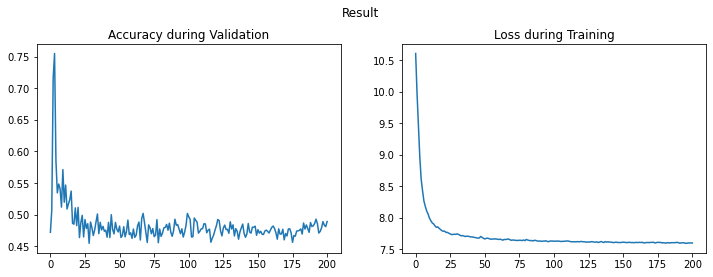

In [15]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

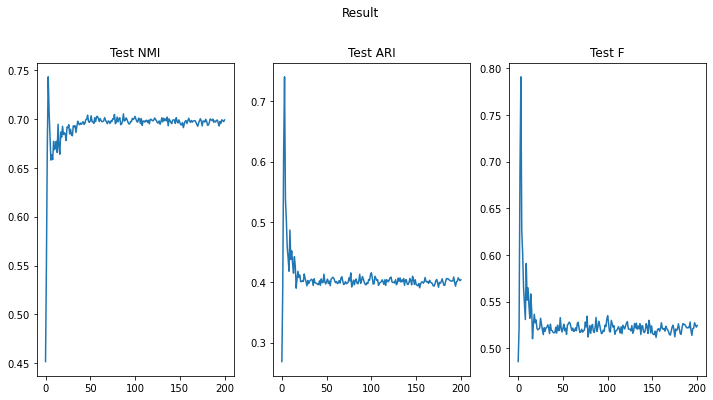

In [16]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
ax[0].plot(nmis)
ax[0].set_title('Test NMI')
ax[1].plot(aris)
ax[1].set_title('Test ARI')
ax[2].plot(fs)
ax[2].set_title('Test F')


plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()